<a href="https://colab.research.google.com/github/Woodruff-Scientific-Ltd/PyFECONS/blob/main/IFE/PyCosting_ARPA_E_IFE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyFECONS

In [1]:
repo_name = "PyFECONS"
project = "IFE"
PAT = 'ENTER PAT HERE'

In [2]:
#INSTALL PACKAGES
#----FIRST TIME ONLY------
#Have to do this every time colab resets :/
!apt-get update

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [50.4 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,346 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd6

In [3]:
import os

# Set your GitHub credentials and repository name
os.environ['GITHUB_AUTH'] = PAT

# Clone the repository using the token for authentication
repo_url = f"https://${{GITHUB_AUTH}}@github.com/Woodruff-Scientific-Ltd/{repo_name}"
!git clone {repo_url}
!git pull {repo_url}
!git config --global user.name "Alex-WSci"
!git config --global user.email "alex@woodruffscientific.com"

# Change directory to the cloned repository using Python command
os.chdir(f'/content/{repo_name}')
!ls

Cloning into 'PyFECONS'...
remote: Enumerating objects: 244, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 244 (delta 24), reused 48 (delta 3), pack-reused 161
Receiving objects: 100% (244/244), 4.30 MiB | 24.45 MiB/s, done.
Resolving deltas: 100% (73/73), done.
fatal: not a git repository (or any of the parent directories): .git
IFE  MFE  MIF  README.md


# Cost Code
(run from here when making updates)

In [4]:
#Libraries

materials = {
    "FS": {"rho": 7470, "c_raw": 10, "m": 3, "sigma": 450},
    "Pb": {"rho": 9400, "c_raw": 2.4, "m": 1.5},
    "Li4SiO4": {"rho": 2390, "c_raw": 1, "m": 2},
    "FLiBe": {"rho": 1900, "c": 40},
    "W": {"rho": 19300, "c_raw": 100, "m": 3},
    "Li": {"rho": 534, "c_raw": 70, "m": 1.5},
    "BFS": {"rho": 7800, "c_raw": 30, "m": 2},
    "PbLi": {"rho": None, "c": None},  # To be calculated
    "SiC": {"rho": 3200, "c_raw": 14.49, "m": 3},
    "Inconel": {"rho": 8440, "c_raw": 46, "m": 3},
    "Cu": {"rho": 7300, "c_raw": 10.2, "m": 3},
    "Polyimide": {"rho": 1430, "c_raw": 100, "m": 3},
    "YBCO": {"rho": 6200, "c": 55},
    "Concrete": {"rho": 2300, "c_raw": 13/25, "m": 2},
    "SS316": {"rho": 7860, "c_raw": 2, "m": 2, "sigma": 900},
    "Nb3Sn": {"c": 5},
    "Incoloy": {"rho": 8170, "c_raw": 4, "m": 2},
    "GdBCO": {},  # Density and cost not provided
    "He": {},  # Density and cost not provided
    "NbTi": {},  # Density and cost not provided
    "Be":{"rho": 1850, "c_raw": 5750.00, "m": 3},
    "Li2TiO3":{"rho": 3430, "c_raw": 1297.05, "m": 3},
}

pblir = 10
materials["PbLi"]["rho"] = (materials["Pb"]["rho"] * pblir + materials["Li"]["rho"]) / (pblir + 1)
materials["PbLi"]["c"] = (materials["Pb"]["c_raw"] * materials["Pb"]["m"] * pblir + materials["Li"]["c_raw"] * materials["Li"]["m"]) / (pblir + 1)


blanket = {
    "firstWall": ["tungsten", "liquid lithium", "beryllium", "FLiBe"],
    "blanketType": [
        "flowing liquid first wall",
        "solid first wall with a liquid breeder",
        "solid first wall with a solid breeder (Li4SiO4)",
        "solid first wall with a solid breeder (Li2TiO3)",
        "solid first wall, no breeder (anuetronic fuel)"
    ],
    "primaryCoolant": [
        "Lead Lithium (PbLi)", "Lithium (Li)", "FLiBe",
        "other eutectic salt", "helium",
        "dual coolant: PbLi and He", "water"
    ],
    "secondaryCoolant": [
        "no", "Lead Lithium (PbLi)", "Lithium (Li)", "FLiBe",
        "other eutectic salt", "helium",
        "dual coolant: PbLi and He", "water"
    ],
    "neutronMultiplier": [
        "no", "Be", "Pb", "Pb as part of PbLi", "Be12Ti"
    ],
    "structure": [
        "Stainless Steel (SS)", "Ferritic Martensitic Steel (FMS)",
        "Oxide Dispersion Strengthened (ODS) Steel", "Vanadium"
    ]
}



In [5]:
#Basic inputs

timetoReplace=10 #years
downTime=1 #years
reactorType=2 #2 is IFE, 1 is IFE, 3 is IFE %input
NMOD=1 #input
AM=1 #input
constructionTime=6 #input
lifeY=30 #lifetime of plant from end of cinstruction
yinflation=0.0245 #inflation at 2.45%
p_a = 0.9 #plant availability factor in Miller 2003 was 0.76
NOAK ="y" #Enter "y" as input if NOAK costing, enter "n" otherwise

firstW = blanket["firstWall"][1]
blanketT = blanket["blanketType"][0]
primaryC = blanket["primaryCoolant"][0]
secondaryC = blanket["secondaryCoolant"][7]
neutronM = blanket["neutronMultiplier"][3]
structure1 = blanket["structure"][1]

In [6]:
import math
from IPython.display import IFrame
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from scipy.interpolate import LinearNDInterpolator
from collections import OrderedDict
import re
from math import log10, floor
from scipy.interpolate import LinearNDInterpolator
from sklearn.linear_model import LinearRegression
import shutil

In [7]:
#Overwriting function
#1)Reads file from 'Originals' directory
#2)Generates copy
#3)Searches copy for placeholders
#4)Overwrites placeholders in copy
#5)Saves copied and overwritten file into 'Modified' directory

base_directory = f"/content/{repo_name}/{project}"
original_directory = os.path.join(base_directory, "Originals")
modified_directory = os.path.join(base_directory, "Modified")
figures_directory = os.path.join(base_directory, "Figures")


def copy_file(filename):
    """
    Copy the file from the original directory to the modified directory.
    """
    original_path = os.path.join(original_directory, filename)
    modified_path = os.path.join(modified_directory, filename)

    try:
        shutil.copyfile(original_path, modified_path)
        print(f"Copied {original_path} to {modified_path}.")
    except FileNotFoundError:
        print(f"The file '{original_path}' does not exist.")
    except Exception as e:
        print(f"An error occurred: {e}")

def overwrite_variable(filename, variable, value):
    """
    Replace a specified variable with the given value in a file within the modified directory.
    The value can be a number or a string.
    """
    modified_path = os.path.join(modified_directory, filename)

    try:
        with open(modified_path, 'r') as file:
            content = file.read()

        # Check if value is nan (using numpy's isnan function) and replace with '-'
        if isinstance(value, float) and np.isnan(value):
            replacement = '-'
        else:
            replacement = str(value)

        content = content.replace(variable, replacement)

        with open(modified_path, 'w') as file:
            file.write(content)

        print(f"Replaced '{variable}' with '{replacement}' in '{modified_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


# Function to safely round values
def safe_round(value, decimals):
    if isinstance(value, float):
        return round(value, decimals)
    return value


def round_to_2(x):
    # Ensure x is a float before checking for np.isnan
    if isinstance(x, float) and np.isnan(x):
        return np.nan
    # Process as float for numerical rounding logic
    elif isinstance(x, (float, int)) and x != 0:
        return round(float(x), 1 - int(floor(log10(abs(x)))))
    else:
        # Directly return x for 0 or non-numeric types that don't need rounding
        return x

In [8]:
#power balance

#-All power values are in MW-
# Fusion Power
PNRL = 2502
# Charged particle power
PALPHA = PNRL * 3.52 / 17.58
# Neutron power
PNEUTRON = PNRL - PALPHA
# Neutron energy multiplier
MN = 1.09
# Pumping power capture efficiency
ETAP = 0.5
# Primary Coolant Pumping Power Fraction
FPCPPF = 0.01
# Subsystem and Control Fraction
FSUB = 0.01
# Tritium Systems
PTRIT = 6
# Housekeeping power
PHOUSE = 4 * 300 / 560
# Auxiliary systems
PAUX = PTRIT + PHOUSE
# Cryo vacuum pumping
PCRYO = 3.57
# Input power wall plug efficiency (implosion)
ETAPIN1 = 0.18
# Input power wall plug efficiency (ignition)
ETAPIN2 = 0.82
# Thermal conversion efficiency
ETATH = 0.46
# Implosion laser power
PIMPLOSION = 10
# Ignition laser power
PIGNITION = 11.22
# Input power
PIN = PIMPLOSION + PIGNITION
# Thermal power
PTH = MN * PNEUTRON + PALPHA + PIN + ETATH * (FPCPPF* ETAP + FSUB) * (MN * PNEUTRON + PALPHA)
# Total (Gross) Electric Power
PET = ETATH * PTH
# Lost Power
PLOSS = PTH - PET
# Gain in Electric Power
GAINE = PET / PIN
# Power into target factory
PTARGET = 0.1
# Power into machinery
PMACHINERY = 0.1
# Primary Coolant Pumping Power
PP = FPCPPF* PET
# Subsystem and Control Power
PSUB = FSUB * PET
# Scientific Q
QS = PNRL / PIN
# Engineering Q
QE = ETATH * (MN * PNEUTRON + PALPHA + PP + PIN) / (PTARGET + PP + PSUB + PAUX + PCRYO + PIMPLOSION / ETAPIN1 + PIGNITION / ETAPIN2)
# Recirculating power fraction
EPSILON = 1 / QE
# Output Power (Net Electric Power)
PNET = (1 - 1 / QE) * PET


PT_dict = {
    'PNRL': PNRL, 'PALPHA': PALPHA, 'PNEUTRON': PNEUTRON, 'MN': MN,  'FPCPPF': FPCPPF,
    'FSUB': FSUB, 'PTRIT': PTRIT, 'PHOUSE': PHOUSE, 'PAUX': PAUX, 'PCRYO': PCRYO, 'ETAPIN1': ETAPIN1,
    'ETAPIN2': ETAPIN2, 'ETAP': ETAP, 'ETATH': ETATH, 'PIMPLOSION': PIMPLOSION, 'PIGNITION': PIGNITION,
     'PTH': PTH, 'PET': PET, 'PLOSS': PLOSS, 'GAINE': GAINE, 'PTARGET': PTARGET,
    'PMACHINERY': PMACHINERY,  'PSUB': PSUB, 'QS': QS, 'QE': QE, 'EPSILON': EPSILON,
    'PNET': PNET,  'PP': PP, 'PIN': PIN,
}


# Loop through the dictionary and overwrite each variable
copy_file('powerTableIFEDT.tex')
for var_name, var_value in PT_dict.items():
    overwrite_variable('powerTableIFEDT.tex', var_name, round(var_value,1))

Copied /content/PyFECONS/IFE/Originals/powerTableIFEDT.tex to /content/PyFECONS/IFE/Modified/powerTableIFEDT.tex.
Replaced 'PNRL' with '2502' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'PALPHA' with '501.0' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'PNEUTRON' with '2001.0' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'MN' with '1.1' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'FPCPPF' with '0.0' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'FSUB' with '0.0' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'PTRIT' with '6' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'PHOUSE' with '2.1' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'PAUX' with '8.1' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'PCRYO' with '3.6' in '/content/PyFECONS/IFE/Modified/powerTableIFEDT.tex'.
Replaced 'ETAPIN1' with '0.2' in

In [9]:
#Cost Category 10: Pre-construction Costs

#Cost Category 11: Land and Land Rights

C110000 = np.sqrt(NMOD) * (PNEUTRON /239 * 0.9 + PNRL/239*0.9)

#Cost Category 12 – Site Permits

C120000 = 10

#Cost Category 13 – Plant Licensing
# https://world-nuclear.org/information-library/economic-aspects/economics-of-nuclear-power.aspx

C130000 = 200

#Cost Category 14 – Plant Permits

C140000 = 5

#Cost Category 15 – Plant Studies

C150000 = 5

#Cost Category 16 – Plant Reports

C160000 = 2

#Cost Category 17 – Other Pre-Construction Costs

C170000 = 1

#Cost Cetegory 19 - Contingency

if NOAK =="y":
  C190000 = 0
else:
  C190000 = 0.1 * (C110000 + C120000 + C130000 + C140000 + C150000 + C160000 + C170000)

#Cost Category 10

C100000 = C110000 + C120000 + C130000 + C140000 + C150000 + C160000 + C170000

copy_file('CAS100000.tex')
overwrite_variable('CAS100000.tex', 'Nmod', NMOD)
overwrite_variable('CAS100000.tex', 'C100000', round(C100000))
overwrite_variable('CAS100000.tex', 'C110000', round(C110000))
overwrite_variable('CAS100000.tex', 'C120000', round(C120000))
overwrite_variable('CAS100000.tex', 'C130000', round(C130000))
overwrite_variable('CAS100000.tex', 'C140000', round(C140000))
overwrite_variable('CAS100000.tex', 'C150000', round(C150000))
overwrite_variable('CAS100000.tex', 'C160000', round(C160000))
overwrite_variable('CAS100000.tex', 'C170000', round(C170000))
overwrite_variable('CAS100000.tex', 'C190000', round(C190000))

Copied /content/PyFECONS/IFE/Originals/CAS100000.tex to /content/PyFECONS/IFE/Modified/CAS100000.tex.
Replaced 'Nmod' with '1' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C100000' with '240' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C110000' with '17' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C120000' with '10' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C130000' with '200' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C140000' with '5' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C150000' with '5' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C160000' with '2' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C170000' with '1' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.
Replaced 'C190000' with '0' in '/content/PyFECONS/IFE/Modified/CAS100000.tex'.


In [10]:
#Cost Category 21: Buildings

#Buildings come out to be 470$/kW gross, so if we are looking at a gross power of 1GW, we have:


#21.01.00,,Site improvements and facs,,20.7,,,,,2019,1.19,

C210100 = 268/1e3 * PET

#21.02.00,,Fusion Heat Island Building,Concrete & Steel,131.6,48.3,48.3,60,140000,2009,1.42,

C210200 = 186.8/1e3 * PET

#21.03.00,,Turbine building,Steel ,45.3,48.3,48.3,30,70000,2019,1.19,

C210300 = 54.0/1e3 * PET

#21.04.00,,Heat exchanger building,Concrete & Steel,31.7,48.3,48.3,15,35000,2019,1.19,

C210400 = 37.8/1e3 * PET

#21.05.00,,Power supply & energy storage,Concrete & Steel,9.1,9.7,9.7,6.0,560,2019,1.19,

C210500 = 10.8/1e3 * PET
#21.06.00,,Reactor auxiliaries,Concrete & Steel,4.5,4.8,4.8,3.0,70,2019,1.19,

C210600 = 5.4/1e3 * PET

#21.07.00,,Hot cell,Concrete & Steel,65.8,24.2,24.2,60,35000,2013,1.42,

C210700 = 93.4/1e3 * PET

#21.08.00,,Reactor services,Steel frame,13.2,4.8,4.8,10,233,2013,1.42,

C210800 = 18.7/1e3 * PET

#21.09.00,,Service water,Steel frame,0.2,1.3,4.0,4.0,21,2019,1.19,

C210900 = 0.3/1e3 * PET

#21.10.00,,Fuel storage,Steel frame,0.9,5.0,15.0,2.5,188,2019,1.19,

C211000 = 1.1/1e3 * PET

#21.11.00,,Control room,Steel frame,0.7,4.0,12.0,2,96,2019,1.19,

C211100 = 0.9/1e3 * PET

#21.12.00,,Onsite AC power,Steel frame,0.7,3.6,10.8,1.8,70,2019,1.19,

C211200 = 0.8/1e3 * PET

#21.13.00,,Administration,Steel frame,3.7,20.0,60.0,10,12000,2019,1.19,

C211300 = 4.4/1e3 * PET

#21.14.00,,Site services,Steel frame,1.3,7.3,22.0,3.7,593,2019,1.19,

C211400 = 1.6/1e3 * PET

#21.15.00,,Cryogenics,Steel frame,2.0,11.0,33.0,5.5,2003,2019,1.19,

C211500 = 2.4/1e3 * PET

#21.16.00,,Security,Steel frame,0.7,4.0,12.0,2,96,2019,1.19,

C211600 = 0.9/1e3 * PET

#21.17.00,,Ventilation stack,Steel cylinder & concrete foundation,22.7,,,120,,2019,1.19,

C211700 = 27.0/1e3 * PET

C210000 = C210100 + C210200 + C210300 + C210400 + C210500 + C210600 + C210700 + C210800 + C210900 + C211000 + C211100 + C211200 + C211300 + C211400 + C211500 + C211600 + C211700



if NOAK =="y":
  C211900 = 0
else:
  C211900 = 0.1*C210000 #10% contingency

C210000 = C210000+C211900

copy_file('CAS210000.tex')
overwrite_variable('CAS210000.tex', 'C210000', round(C210000,1))
overwrite_variable('CAS210000.tex', 'C210100', round(C210100,1))
overwrite_variable('CAS210000.tex', 'C210200', round(C210200,1))
overwrite_variable('CAS210000.tex', 'C210300', round(C210300,1))
overwrite_variable('CAS210000.tex', 'C210400', round(C210400,1))
overwrite_variable('CAS210000.tex', 'C210500', round(C210500,1))
overwrite_variable('CAS210000.tex', 'C210600', round(C210600,1))
overwrite_variable('CAS210000.tex', 'C210700', round(C210700,1))
overwrite_variable('CAS210000.tex', 'C210800', round(C210800,1))
overwrite_variable('CAS210000.tex', 'C210900', round(C210900,1))
overwrite_variable('CAS210000.tex', 'C210000', round(C210000,1))
overwrite_variable('CAS210000.tex', 'C211000', round(C211000,1))
overwrite_variable('CAS210000.tex', 'C211100', round(C211100,1))
overwrite_variable('CAS210000.tex', 'C211200', round(C211200,1))
overwrite_variable('CAS210000.tex', 'C211300', round(C211300,1))
overwrite_variable('CAS210000.tex', 'C211400', round(C211400,1))
overwrite_variable('CAS210000.tex', 'C211500', round(C211500,1))
overwrite_variable('CAS210000.tex', 'C211600', round(C211600,1))
overwrite_variable('CAS210000.tex', 'C211700', round(C211700,1))
overwrite_variable('CAS210000.tex', 'C211900', round(C211900,1))

Copied /content/PyFECONS/IFE/Originals/CAS210000.tex to /content/PyFECONS/IFE/Modified/CAS210000.tex.
Replaced 'C210000' with '894.3' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210100' with '335.5' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210200' with '233.9' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210300' with '67.6' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210400' with '47.3' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210500' with '13.5' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210600' with '6.8' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210700' with '116.9' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210800' with '23.4' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210900' with '0.4' in '/content/PyFECONS/IFE/Modified/CAS210000.tex'.
Replaced 'C210000' with '894.3' in '/content/PyFECONS/IFE/Modified/CAS210000

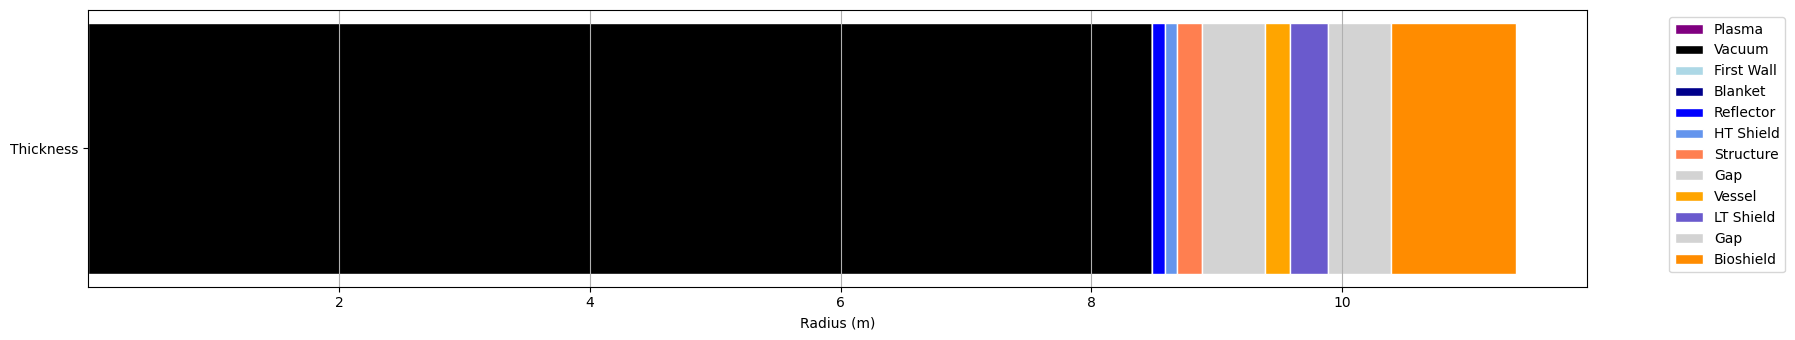

Copied /content/PyFECONS/IFE/Originals/CAS220101_IFE_DT.tex to /content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex.
Replaced 'TH14' with '1' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'RAD14I' with '10.4' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'RAD14O' with '11.4' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'VOL14' with '1490.0' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'TH13' with '0.5' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'RAD13I' with '10.4' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'RAD13O' with '10.4' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'VOL13' with '645.5' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'TH12' with '0.3' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'RAD12I' with '9.9' in '/content/PyFECONS/IFE/Modified/CAS220101_IFE_DT.tex'.
Replaced 'RAD12

In [11]:
#Cost Category 22.1.1: Reactor Equipment

"""
CALCS
"""

# Radial build inputs
# Radial thicknesses of concentric components (innermost to outermost)
axis_t = 0  # [m] distance from r=0 to plasma central axis
plasma_t = 0.0001  # [m] plasma radial thickness
vacuum_t = 8.48  # [m] vacuum radial thickness
firstwall_t = 0.005  # [m] first wall radial thickness
blanket1_t = 0  # [m] blanket radial thickness
reflector_t = 0.1  # [m] reflector radial thickness
ht_shield_t = 0.1  # [m] High-temperature shield radial thickness
structure_t = 0.2  # [m] support structure radial thickness
gap1_t = 0.5  # [m] air gap radial thickness
vessel_t = 0.2  # [m] vacuum vessel wall radial thickness
gap2_t = 0.5  # [m] second air gap radial thickness
lt_shield_t = 0.3  # [m] low-temperature shield radial thickness
bioshield_t = 1  # [m] concrete bioshield radial thickness


# Inner radii adjustments
axis_ir = axis_t
plasma_ir = axis_ir
vacuum_ir = plasma_t + plasma_ir
firstwall_ir = vacuum_t + vacuum_ir
blanket1_ir = firstwall_ir + firstwall_t
reflector_ir = blanket1_ir + blanket1_t
ht_shield_ir = reflector_ir + reflector_t
structure_ir = ht_shield_ir + ht_shield_t
gap1_ir = structure_ir + structure_t
vessel_ir = gap1_ir + gap1_t
lt_shield_ir = vessel_ir + vessel_t  # Adjusted lt_shield inner radius
gap2_ir = lt_shield_ir + lt_shield_t  # Adjusted gap2 inner radius directly after lt_shield
bioshield_ir = gap2_ir + gap2_t  # Adjusted bioshield inner radius

# Outer radii adjustments
axis_or = axis_ir + axis_t
plasma_or = plasma_ir + plasma_t
vacuum_or = vacuum_ir + vacuum_t
firstwall_or = firstwall_ir + firstwall_t
blanket1_or = blanket1_ir + blanket1_t
reflector_or = reflector_ir + reflector_t
ht_shield_or = ht_shield_ir + ht_shield_t
structure_or = structure_ir + structure_t
gap1_or = gap1_ir + gap1_t
vessel_or = vessel_ir + vessel_t
lt_shield_or = lt_shield_ir + lt_shield_t  # Adjusted lt_shield outer radius
gap2_or = gap2_ir + gap2_t  # Adjusted gap2 outer radius directly after lt_shield
bioshield_or = bioshield_ir + bioshield_t  # Adjusted bioshield outer radius

# Volumes for sphere
def calc_volume(inner, outer):
    return 4/3 * np.pi * (outer**3 - inner**3)

axis_vol = calc_volume(axis_ir, axis_or)
plasma_vol = calc_volume(plasma_ir, plasma_or)
vacuum_vol = calc_volume(vacuum_ir, vacuum_or)
firstwall_vol = calc_volume(firstwall_ir, firstwall_or)
blanket1_vol = calc_volume(blanket1_ir, blanket1_or)
reflector_vol = calc_volume(reflector_ir, reflector_or)
ht_shield_vol = calc_volume(ht_shield_ir, ht_shield_or)
structure_vol = calc_volume(structure_ir, structure_or)
gap1_vol = calc_volume(gap1_ir, gap1_or)
vessel_vol = calc_volume(vessel_ir, vessel_or)
lt_shield_vol = calc_volume(lt_shield_ir, lt_shield_or)
gap2_vol = calc_volume(gap2_ir, gap2_or)
bioshield_vol = calc_volume(bioshield_ir, bioshield_or)

#First wall
if firstW == "tungsten":
  C22010101 = firstwall_vol*materials["W"]["rho"]*materials["W"]["c_raw"]*materials["W"]["m"]/1e6
elif firstW == "liquid lithium":
  C22010101 = firstwall_vol*materials["Li"]["rho"]*materials["Li"]["c_raw"]*materials["Li"]["m"]/1e6
elif firstW == "beryllium":
  C22010101 = firstwall_vol*materials["Be"]["rho"]*materials["Be"]["c_raw"]*materials["Be"]["m"]/1e6
elif firstW == "FLiBe":
  C22010101 = firstwall_vol*materials["FliBe"]["rho"]*materials["FliBe"]["c_raw"]*materials["FliBe"]["m"]/1e6

#Blanket

if blanketT == "flowing liquid first wall":
  C22010102 = blanket1_vol*materials["Li"]["rho"]*materials["Li"]["c_raw"]*materials["Li"]["m"]/1e6
elif blanketT == "solid first wall with a liquid breeder":
  C22010102 = blanket1_vol*materials["Li"]["rho"]*materials["Li"]["c_raw"]*materials["Li"]["m"]/1e6
elif blanketT == "solid first wall with a solid breeder (Li4SiO4)":
  C22010102 = blanket1_vol*materials["Li4SiO4"]["rho"]*materials["Li4SiO4"]["c_raw"]*materials["Li4SiO4"]["m"]/1e6
elif blanketT == "solid first wall with a solid breeder (Li2TiO3)":
  C22010102 = blanket1_vol*materials["Li2TiO3"]["rho"]*materials["Li2TiO3"]["c_raw"]*materials["Li2TiO3"]["m"]/1e6
elif blanketT == "solid first wall, no breeder (anuetronic fuel)":
  C22010102 = 0


C220101 = C22010101+C22010102 #Total cost of blanket and first wall

"""
PLOTTING RADIAL BUILD
"""

sections = ['Plasma', 'Vacuum', 'First Wall', 'Blanket', 'Reflector', 'HT Shield', 'Structure', 'Gap', 'Vessel', 'LT Shield', 'Gap', 'Bioshield']
thickness = [plasma_t, vacuum_t, firstwall_t, blanket1_t, reflector_t, ht_shield_t, structure_t, gap1_t, vessel_t, lt_shield_t, gap2_t, bioshield_t]
colors = ['purple', 'black', 'lightblue', 'darkblue', 'blue', 'cornflowerblue', 'coral', 'lightgray', 'orange', 'slateblue', 'lightgray', 'darkorange']

# Plotting the stacked bar graph
fig, ax = plt.subplots(figsize=(18, 3.5)) # Adjust the figsize to get the desired aspect ratio

# Adding each section to the bar plot
left = 0  # Initialize left at 0
for i, (section, thk) in enumerate(zip(sections, thickness)):
    ax.barh('Thickness', thk, left=left, color=colors[i], edgecolor='white', label=section)
    left += thk  # Increment left by the thickness of the current section

# Setting labels and title
ax.set_xlabel('Radius (m)')

# Creating the legend
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Show grid for the x-axis
ax.xaxis.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

# Export as pdf
fig.savefig(os.path.join(figures_directory, 'radial_build.pdf'), bbox_inches='tight')


#Template hydration
output_values = {
    'TH14': (bioshield_t, 1), 'RAD14I': (bioshield_ir, 1), 'RAD14O': (bioshield_or, 1), 'VOL14': (bioshield_vol, 1),
    'TH13': (gap2_t, 1), 'RAD13I': (gap2_or, 1), 'RAD13O': (gap2_or, 1), 'VOL13': (gap2_vol, 1),
    'TH12': (lt_shield_t, 1), 'RAD12I': (lt_shield_or, 1), 'RAD12O': (lt_shield_or, 1), 'VOL12': (lt_shield_vol, 1),
    'TH10': (lt_shield_t, 1), 'RAD10I': (lt_shield_or, 1), 'RAD10O': (lt_shield_or, 1), 'VOL10': (lt_shield_vol, 1),
    'TH9': (ht_shield_t, 1), 'RAD9I': (ht_shield_or, 1), 'RAD9O': (ht_shield_or, 1), 'VOL9': (ht_shield_vol, 1),
    'TH8': (vessel_t, 1), 'RAD8I': (vessel_or, 1), 'RAD8O': (vessel_or, 1), 'VOL8': (vessel_vol, 1),
    'TH7': (gap1_t, 1), 'RAD7I': (gap1_or, 1), 'RAD7O': (gap1_or, 1), 'VOL7': (gap1_vol, 1),
    'TH6': (reflector_t, 1), 'RAD6I': (reflector_or, 1), 'RAD6O': (reflector_or, 1), 'VOL6': (reflector_vol, 1),
    'TH5': (structure_t, 1), 'RAD5I': (structure_or, 1), 'RAD5O': (structure_or, 1), 'VOL5': (structure_vol, 1),
    'TH4': (blanket1_t, 1), 'RAD4I': (blanket1_or, 1), 'RAD4O': (blanket1_or, 1), 'VOL4': (blanket1_vol, 1),
    'TH3': (firstwall_t, 1), 'RAD3I': (firstwall_or, 1), 'RAD3O': (firstwall_or, 1), 'VOL3': (firstwall_vol, 1),
    'TH2': (vacuum_t, 1), 'RAD2I': (vacuum_or, 1), 'RAD2O': (vacuum_or, 1), 'VOL2': (vacuum_vol, 1),
    'TH1': (plasma_t, 1), 'RAD1I': (plasma_or, 1), 'RAD1O': (plasma_or, 1), 'VOL1': (plasma_vol, 1),
    'primaryC': primaryC, 'secondaryC': secondaryC, 'neutronM': neutronM,
    'structure1': structure1, 'firstW': firstW
}


# Copying the .tex file
copy_file('CAS220101_IFE_DT.tex')
# Overwriting the placeholders in the .tex file
for var_name, var_value in output_values.items():
    if isinstance(var_value, tuple):
        overwrite_variable('CAS220101_IFE_DT.tex', var_name, round(var_value[0], var_value[1]))
    elif var_name in ['primaryC', 'secondaryC', 'neutronM', 'structure1', 'firstW']:
        overwrite_variable('CAS220101_IFE_DT.tex', var_name, var_value)
overwrite_variable('CAS220101_IFE_DT.tex', "C22010101", round_to_2(C22010101))
overwrite_variable('CAS220101_IFE_DT.tex', "C22010102", round_to_2(C22010102))
overwrite_variable('CAS220101_IFE_DT.tex', "C220101", round_to_2(C220101))


In [12]:
#Cost Category 22.1.2: Shield

"""
CALCS
"""
# Define the fractions
f_SiC = 0.00
FPCPPFbLi = 0.1
f_W = 0.00
f_BFS = 0.9

# Retrieve the volume of HTS from the reactor_volumes dictionary
#V_HTS = volumes["V_HTS"]
V_HTS = round(ht_shield_vol,1)

# Calculate the cost for HTS
C_HTS = round(V_HTS * (
    materials["SiC"]["rho"] * materials["SiC"]["c_raw"] * materials["SiC"]["m"] * f_SiC +
    materials["PbLi"]["rho"] * materials["PbLi"]["c"] * FPCPPFbLi +
    materials["W"]["rho"] * materials["W"]["c_raw"] * materials["W"]["m"] * f_W +
    materials["BFS"]["rho"] * materials["BFS"]["c_raw"] * materials["BFS"]["m"] * f_BFS
) / 1e6,1)

# Volume of HTShield that is BFS
V_HTS_BFS = V_HTS * f_BFS
# The cost C_22_1_2 is the same as C_HTS
C22010201 = round(C_HTS,1)*5
C22010202 = lt_shield_vol*materials["SS316"]["c_raw"]*materials["SS316"]["m"]/1e3
C22010203 = bioshield_vol*materials["SS316"]["c_raw"]*materials["SS316"]["m"]/1e3
C22010204 = C22010203*0.1
C220102 = C22010201+C22010202+C22010203+C22010204


copy_file('CAS220102.tex')
overwrite_variable('CAS220102.tex', 'C22010201', round(C22010201))
overwrite_variable('CAS220102.tex', 'C22010202', round(C22010202))
overwrite_variable('CAS220102.tex', 'C22010203', round(C22010203))
overwrite_variable('CAS220102.tex', 'C22010204', round(C22010204))
overwrite_variable('CAS220102.tex', 'C220102', round(C220102))
overwrite_variable('CAS220102.tex', 'V220102', round(V_HTS))
overwrite_variable('CAS220102.tex', 'primaryC', primaryC)
overwrite_variable('CAS220102.tex', 'VOL9', round(ht_shield_vol))
overwrite_variable('CAS220102.tex', 'VOL10', round(lt_shield_vol))
overwrite_variable('CAS220102.tex', 'VOL14', round(bioshield_vol))

Copied /content/PyFECONS/IFE/Originals/CAS220102.tex to /content/PyFECONS/IFE/Modified/CAS220102.tex.
Replaced 'C22010201' with '202' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'C22010202' with '1' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'C22010203' with '6' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'C22010204' with '1' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'C220102' with '210' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'V220102' with '94' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'primaryC' with 'Lead Lithium (PbLi)' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'VOL9' with '94' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'VOL10' with '357' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.
Replaced 'VOL14' with '1490' in '/content/PyFECONS/IFE/Modified/CAS220102.tex'.


In [13]:
#Cost Category 22.1.3: Lasers

#INPUTS

#System Energy
LENERGY=15
#Learning curve cost or time reduction between first and nth beamlet construction (default 5x)
BLCURVE=5

#Calcs
NIFLENERGY=4.7 #[MJ] NIF Laser energy for scaling (see https://docs.google.com/spreadsheets/d/1sMNzOweYvZCR1BeCXR4IciHEikYyZ0a11XpnLshR6DU/edit#gid=1102621340 for justification of linear scaling)
Bb=np.log(1/5)/np.log(288) #Beamlet learning curve coefficient b

#This dictionary contains the NIF 2023 adjusted construction only costs (i.e. excluding pilot+production) for each
NIF_costs = {
    "22.1.3. Laser": {"Procurement": 887.6, "Design": 61.2, "Assembly": 166.5, "Total": 989.5},
    "22.1.3.1 Front End": {"Procurement": 75.0, "Design": 9.1, "Assembly": 16.0, "Total": 100.0},
    "22.1.3.2 Main Amp System": {"Procurement": 200.7, "Design": 11.1, "Assembly": 33.2, "Total": 244.9},
      "22.1.3.2.1 Main Amp": {"Procurement": 85.3, "Design": 5.0, "Assembly": 10.2, "Total": 100.5},
      "22.1.3.2.1.1 Flashlamp Assemblies": {"Procurement": 21.5, "Design": 0.0, "Assembly": 0.0, "Total": 21.5},
      "22.1.3.2.1.3, 3.2.1.5-7 (amp mech)": {"Procurement": 63.9, "Design": 5.0, "Assembly": 10.2, "Total": 79.1},
      "22.1.3.2.2 Spatial filters": {"Procurement": 27.4, "Design": 0.6, "Assembly": 6.0, "Total": 33.9},
      "22.1.3.2.3 Mirror Mounts": {"Procurement": 10.0, "Design": 0.1, "Assembly": 1.0, "Total": 11.1},
      "22.1.3.2.4 Polarizer assembly": {"Procurement": 5.2, "Design": 0.7, "Assembly": 2.7, "Total": 8.5},
      "22.1.3.2.5 Pockels' Cell Assembly": {"Procurement": 52.6, "Design": 4.7, "Assembly": 11.1, "Total": 68.4},
      "22.1.3.2.6 Boost Amp": {"Procurement": 17.9, "Design": 0.0, "Assembly": 2.2, "Total": 20.1},
      "22.1.3.2.6.1 Flashlamp Assemblies": {"Procurement": 4.6, "Design": 0.0, "Assembly": 0.0, "Total": 4.6},
      "22.1.3.2.6.3, 3.2.6.5-7 (amp mech)": {"Procurement": 13.3, "Design": 0.0, "Assembly": 2.2, "Total": 15.5},
      "22.1.3.2.7 Interstage Hdw": {"Procurement": 2.4, "Design": 0.0, "Assembly": 0.1, "Total": 2.5},
    "22.1.3.3 Beam Xport system": {"Procurement": 56.9, "Design": 2.8, "Assembly": 9.5, "Total": 138.4},
      "22.1.3.3.1 Spatial filters": {"Procurement": 31.1, "Design": 2.3, "Assembly": 0.0, "Total": 69.2},
      "22.1.3.3.2 Mirror Assembly": {"Procurement": 8.4, "Design": 0.1, "Assembly": 7.2, "Total": 40.6},
      "22.1.3.3.3 Final Optics system": {"Procurement": 12.5, "Design": 0.3, "Assembly": 0.9, "Total": 9.4},
      "22.1.3.3.4 Beam Tube system": {"Procurement": 4.9, "Design": 0.1, "Assembly": 1.3, "Total": 14.1},
      "22.1.3.3.5 Interstage Hdw": {"Procurement": 0.0, "Design": 0.0, "Assembly": 0.1, "Total": 5.0},
    "22.1.3.4 Power cond system": {"Procurement": 98.7, "Design": 0.0, "Assembly": 0.0, "Total": 98.7},
    "22.1.3.5 Align and Laser diag": {"Procurement": 71.4, "Design": 15.8, "Assembly": 48.8, "Total": 136.1},
    "22.1.3.6 Space frame": {"Procurement": 22.5, "Design": 3.6, "Assembly": 0.0, "Total": 26.1},
    "22.1.3.7 Laser aux systems": {"Procurement": 1.5, "Design": 0.0, "Assembly": 4.0, "Total": 5.5},
    "22.1.3.8 Optics": {"Procurement": 0.0, "Design": 0.0, "Assembly": 0.0, "Total": 239.8}
}

#Optics NIF subsystem breakdown, totals only, see https://docs.google.com/spreadsheets/d/1sMNzOweYvZCR1BeCXR4IciHEikYyZ0a11XpnLshR6DU/edit#gid=1467969509 for more detail
NIF_optics_costs = {
    "Laser glass slabs (phosphate)": {"Totals Full System": 121.50356, "Totals Beamlet": 419.2936},
    "Spatial filter lenses (SiO2)": {"Totals Full System": 18.063248, "Totals Beamlet": 62.2856},
    "Final focus lenses (SiO2)": {"Totals Full System": 5.599344, "Totals Beamlet": 19.2708},
    "Vacuum windows (SiO2)": {"Totals Full System": 4.898472, "Totals Beamlet": 16.9176},
    "Debris shields (SiO2)": {"Totals Full System": 4.947232, "Totals Beamlet": 17.0872},
    "Pockels cell windows (SiO2)": {"Totals Full System": 7.188708, "Totals Beamlet": 24.7828},
    "Polariser (HiQ BK7)": {"Totals Full System": 13.7853, "Totals Beamlet": 47.5516},
    "Doubler crystal (KDP)": {"Totals Full System": 5.996844, "Totals Beamlet": 20.6912},
    "Tripler crystal (KDP)": {"Totals Full System": 12.533864, "Totals Beamlet": 43.248},
    "PC crystal (KDP)": {"Totals Full System": 14.940912, "Totals Beamlet": 51.5584},
    "Cavity mirrors (BK7)": {"Totals Full System": 11.91652, "Totals Beamlet": 41.1068},
    "Transport mirrors (BK7)": {"Totals Full System": 11.960616, "Totals Beamlet": 41.2552},
    "Elbow mirrors (BK7)": {"Totals Full System": 6.471088, "Totals Beamlet": 22.3236},
    "Totals": {"Totals Full System": 239.805708, "Totals Beamlet": 827.3724}
}


def scaled_costs(nif_costs):

    scaled_costs = {}
    scaling_factor=LENERGY/NIFLENERGY*(LENERGY/NIFLENERGY)**Bb #scales for system energy and learning curve
    for key, values in nif_costs.items():
        scaled_costs[key] = {
            "Procurement": values.get("Procurement", 0) *scaling_factor,
            "Design": values.get("Design", 0) *scaling_factor,
            "Assembly": values.get("Assembly", 0) *scaling_factor,
            "Total": values.get("Procurement", 0)+values.get("Design", 0)+values.get("Assembly", 0)
        }

    return scaled_costs



"""
WRITE TO LATEX
"""
variables_to_overwrite = {
    "2213Procurement": scaled_costs(NIF_costs)["22.1.3. Laser"]["Procurement"],
    "2213Design": scaled_costs(NIF_costs)["22.1.3. Laser"]["Design"],
    "2213Assembly": scaled_costs(NIF_costs)["22.1.3. Laser"]["Assembly"],
    "2213Total": scaled_costs(NIF_costs)["22.1.3. Laser"]["Total"],

    "22131FrontEndProcurement": scaled_costs(NIF_costs)["22.1.3.1 Front End"]["Procurement"],
    "22131FrontEndDesign": scaled_costs(NIF_costs)["22.1.3.1 Front End"]["Design"],
    "22131FrontEndAssembly": scaled_costs(NIF_costs)["22.1.3.1 Front End"]["Assembly"],
    "22131FrontEndTotal": scaled_costs(NIF_costs)["22.1.3.1 Front End"]["Total"],

    "22132MainAmpSystemProcurement": scaled_costs(NIF_costs)["22.1.3.2 Main Amp System"]["Procurement"],
    "22132MainAmpSystemDesign": scaled_costs(NIF_costs)["22.1.3.2 Main Amp System"]["Design"],
    "22132MainAmpSystemAssembly": scaled_costs(NIF_costs)["22.1.3.2 Main Amp System"]["Assembly"],
    "22132MainAmpSystemTotal": scaled_costs(NIF_costs)["22.1.3.2 Main Amp System"]["Total"],

    "221321MainAmpProcurement": scaled_costs(NIF_costs)["22.1.3.2.1 Main Amp"]["Procurement"],
    "221321MainAmpDesign": scaled_costs(NIF_costs)["22.1.3.2.1 Main Amp"]["Design"],
    "221321MainAmpAssembly": scaled_costs(NIF_costs)["22.1.3.2.1 Main Amp"]["Assembly"],
    "221321MainAmpTotal": scaled_costs(NIF_costs)["22.1.3.2.1 Main Amp"]["Total"],

    "2213211FlashlampAssembliesProcurement": scaled_costs(NIF_costs)["22.1.3.2.1.1 Flashlamp Assemblies"]["Procurement"],
    "2213211FlashlampAssembliesDesign": scaled_costs(NIF_costs)["22.1.3.2.1.1 Flashlamp Assemblies"]["Design"],
    "2213211FlashlampAssembliesAssembly": scaled_costs(NIF_costs)["22.1.3.2.1.1 Flashlamp Assemblies"]["Assembly"],
    "2213211FlashlampAssembliesTotal": scaled_costs(NIF_costs)["22.1.3.2.1.1 Flashlamp Assemblies"]["Total"],

    "2213213AmpMechProcurement": scaled_costs(NIF_costs)["22.1.3.2.1.3, 3.2.1.5-7 (amp mech)"]["Procurement"],
    "2213213AmpMechDesign": scaled_costs(NIF_costs)["22.1.3.2.1.3, 3.2.1.5-7 (amp mech)"]["Design"],
    "2213213AmpMechAssembly": scaled_costs(NIF_costs)["22.1.3.2.1.3, 3.2.1.5-7 (amp mech)"]["Assembly"],
    "2213213AmpMechTotal": scaled_costs(NIF_costs)["22.1.3.2.1.3, 3.2.1.5-7 (amp mech)"]["Total"],

    "221322SpatialFiltersProcurement": scaled_costs(NIF_costs)["22.1.3.2.2 Spatial filters"]["Procurement"],
    "221322SpatialFiltersDesign": scaled_costs(NIF_costs)["22.1.3.2.2 Spatial filters"]["Design"],
    "221322SpatialFiltersAssembly": scaled_costs(NIF_costs)["22.1.3.2.2 Spatial filters"]["Assembly"],
    "221322SpatialFiltersTotal": scaled_costs(NIF_costs)["22.1.3.2.2 Spatial filters"]["Total"],

    "221323MirrorMountsProcurement": scaled_costs(NIF_costs)["22.1.3.2.3 Mirror Mounts"]["Procurement"],
    "221323MirrorMountsDesign": scaled_costs(NIF_costs)["22.1.3.2.3 Mirror Mounts"]["Design"],
    "221323MirrorMountsAssembly": scaled_costs(NIF_costs)["22.1.3.2.3 Mirror Mounts"]["Assembly"],
    "221323MirrorMountsTotal": scaled_costs(NIF_costs)["22.1.3.2.3 Mirror Mounts"]["Total"],

    "221324PolarizerAssemblyProcurement": scaled_costs(NIF_costs)["22.1.3.2.4 Polarizer assembly"]["Procurement"],
    "221324PolarizerAssemblyDesign": scaled_costs(NIF_costs)["22.1.3.2.4 Polarizer assembly"]["Design"],
    "221324PolarizerAssemblyAssembly": scaled_costs(NIF_costs)["22.1.3.2.4 Polarizer assembly"]["Assembly"],
    "221324PolarizerAssemblyTotal": scaled_costs(NIF_costs)["22.1.3.2.4 Polarizer assembly"]["Total"],

    "221325PockelsCellAssemblyProcurement": scaled_costs(NIF_costs)["22.1.3.2.5 Pockels' Cell Assembly"]["Procurement"],
    "221325PockelsCellAssemblyDesign": scaled_costs(NIF_costs)["22.1.3.2.5 Pockels' Cell Assembly"]["Design"],
    "221325PockelsCellAssemblyAssembly": scaled_costs(NIF_costs)["22.1.3.2.5 Pockels' Cell Assembly"]["Assembly"],
    "221325PockelsCellAssemblyTotal": scaled_costs(NIF_costs)["22.1.3.2.5 Pockels' Cell Assembly"]["Total"],

    "221326BoostAmpProcurement": scaled_costs(NIF_costs)["22.1.3.2.6 Boost Amp"]["Procurement"],
    "221326BoostAmpDesign": scaled_costs(NIF_costs)["22.1.3.2.6 Boost Amp"]["Design"],
    "221326BoostAmpAssembly": scaled_costs(NIF_costs)["22.1.3.2.6 Boost Amp"]["Assembly"],
    "221326BoostAmpTotal": scaled_costs(NIF_costs)["22.1.3.2.6 Boost Amp"]["Total"],

    "2213261FlashlampAssembliesProcurement": scaled_costs(NIF_costs)["22.1.3.2.6.1 Flashlamp Assemblies"]["Procurement"],
    "2213261FlashlampAssembliesDesign": scaled_costs(NIF_costs)["22.1.3.2.6.1 Flashlamp Assemblies"]["Design"],
    "2213261FlashlampAssembliesAssembly": scaled_costs(NIF_costs)["22.1.3.2.6.1 Flashlamp Assemblies"]["Assembly"],
    "2213261FlashlampAssembliesTotal": scaled_costs(NIF_costs)["22.1.3.2.6.1 Flashlamp Assemblies"]["Total"],

    "2213263AmpMechProcurement": scaled_costs(NIF_costs)["22.1.3.2.6.3, 3.2.6.5-7 (amp mech)"]["Procurement"],
    "2213263AmpMechDesign": scaled_costs(NIF_costs)["22.1.3.2.6.3, 3.2.6.5-7 (amp mech)"]["Design"],
    "2213263AmpMechAssembly": scaled_costs(NIF_costs)["22.1.3.2.6.3, 3.2.6.5-7 (amp mech)"]["Assembly"],
    "2213263AmpMechTotal": scaled_costs(NIF_costs)["22.1.3.2.6.3, 3.2.6.5-7 (amp mech)"]["Total"],

    "221327InterstageHdwProcurement": scaled_costs(NIF_costs)["22.1.3.2.7 Interstage Hdw"]["Procurement"],
    "221327InterstageHdwDesign": scaled_costs(NIF_costs)["22.1.3.2.7 Interstage Hdw"]["Design"],
    "221327InterstageHdwAssembly": scaled_costs(NIF_costs)["22.1.3.2.7 Interstage Hdw"]["Assembly"],
    "221327InterstageHdwTotal": scaled_costs(NIF_costs)["22.1.3.2.7 Interstage Hdw"]["Total"],

    "22133BeamXportSystemProcurement": scaled_costs(NIF_costs)["22.1.3.3 Beam Xport system"]["Procurement"],
    "22133BeamXportSystemDesign": scaled_costs(NIF_costs)["22.1.3.3 Beam Xport system"]["Design"],
    "22133BeamXportSystemAssembly": scaled_costs(NIF_costs)["22.1.3.3 Beam Xport system"]["Assembly"],
    "22133BeamXportSystemTotal": scaled_costs(NIF_costs)["22.1.3.3 Beam Xport system"]["Total"],

    "221331SpatialFiltersProcurement": scaled_costs(NIF_costs)["22.1.3.3.1 Spatial filters"]["Procurement"],
    "221331SpatialFiltersDesign": scaled_costs(NIF_costs)["22.1.3.3.1 Spatial filters"]["Design"],
    "221331SpatialFiltersAssembly": scaled_costs(NIF_costs)["22.1.3.3.1 Spatial filters"]["Assembly"],
    "221331SpatialFiltersTotal": scaled_costs(NIF_costs)["22.1.3.3.1 Spatial filters"]["Total"],

    "221332MirrorAssemblyProcurement": scaled_costs(NIF_costs)["22.1.3.3.2 Mirror Assembly"]["Procurement"],
    "221332MirrorAssemblyDesign": scaled_costs(NIF_costs)["22.1.3.3.2 Mirror Assembly"]["Design"],
    "221332MirrorAssemblyAssembly": scaled_costs(NIF_costs)["22.1.3.3.2 Mirror Assembly"]["Assembly"],
    "221332MirrorAssemblyTotal": scaled_costs(NIF_costs)["22.1.3.3.2 Mirror Assembly"]["Total"],

    "221333FinalOpticsSystemProcurement": scaled_costs(NIF_costs)["22.1.3.3.3 Final Optics system"]["Procurement"],
    "221333FinalOpticsSystemDesign": scaled_costs(NIF_costs)["22.1.3.3.3 Final Optics system"]["Design"],
    "221333FinalOpticsSystemAssembly": scaled_costs(NIF_costs)["22.1.3.3.3 Final Optics system"]["Assembly"],
    "221333FinalOpticsSystemTotal": scaled_costs(NIF_costs)["22.1.3.3.3 Final Optics system"]["Total"],

    "221334BeamTubeSystemProcurement": scaled_costs(NIF_costs)["22.1.3.3.4 Beam Tube system"]["Procurement"],
    "221334BeamTubeSystemDesign": scaled_costs(NIF_costs)["22.1.3.3.4 Beam Tube system"]["Design"],
    "221334BeamTubeSystemAssembly": scaled_costs(NIF_costs)["22.1.3.3.4 Beam Tube system"]["Assembly"],
    "221334BeamTubeSystemTotal": scaled_costs(NIF_costs)["22.1.3.3.4 Beam Tube system"]["Total"],

    "221335InterstageHdwProcurement": scaled_costs(NIF_costs)["22.1.3.3.5 Interstage Hdw"]["Procurement"],
    "221335InterstageHdwDesign": scaled_costs(NIF_costs)["22.1.3.3.5 Interstage Hdw"]["Design"],
    "221335InterstageHdwAssembly": scaled_costs(NIF_costs)["22.1.3.3.5 Interstage Hdw"]["Assembly"],
    "221335InterstageHdwTotal": scaled_costs(NIF_costs)["22.1.3.3.5 Interstage Hdw"]["Total"],

    "22134PowerCondSystemProcurement": scaled_costs(NIF_costs)["22.1.3.4 Power cond system"]["Procurement"],
    "22134PowerCondSystemDesign": scaled_costs(NIF_costs)["22.1.3.4 Power cond system"]["Design"],
    "22134PowerCondSystemAssembly": scaled_costs(NIF_costs)["22.1.3.4 Power cond system"]["Assembly"],
    "22134PowerCondSystemTotal": scaled_costs(NIF_costs)["22.1.3.4 Power cond system"]["Total"],

    "22135AlignAndLaserDiagProcurement": scaled_costs(NIF_costs)["22.1.3.5 Align and Laser diag"]["Procurement"],
    "22135AlignAndLaserDiagDesign": scaled_costs(NIF_costs)["22.1.3.5 Align and Laser diag"]["Design"],
    "22135AlignAndLaserDiagAssembly": scaled_costs(NIF_costs)["22.1.3.5 Align and Laser diag"]["Assembly"],
    "22135AlignAndLaserDiagTotal": scaled_costs(NIF_costs)["22.1.3.5 Align and Laser diag"]["Total"],

    "22136SpaceFrameProcurement": scaled_costs(NIF_costs)["22.1.3.6 Space frame"]["Procurement"],
    "22136SpaceFrameDesign": scaled_costs(NIF_costs)["22.1.3.6 Space frame"]["Design"],
    "22136SpaceFrameAssembly": scaled_costs(NIF_costs)["22.1.3.6 Space frame"]["Assembly"],
    "22136SpaceFrameTotal": scaled_costs(NIF_costs)["22.1.3.6 Space frame"]["Total"],

    "22137LaserAuxSystemsProcurement": scaled_costs(NIF_costs)["22.1.3.7 Laser aux systems"]["Procurement"],
    "22137LaserAuxSystemsDesign": scaled_costs(NIF_costs)["22.1.3.7 Laser aux systems"]["Design"],
    "22137LaserAuxSystemsAssembly": scaled_costs(NIF_costs)["22.1.3.7 Laser aux systems"]["Assembly"],
    "22137LaserAuxSystemsTotal": scaled_costs(NIF_costs)["22.1.3.7 Laser aux systems"]["Total"],

    "22138OpticsProcurement": scaled_costs(NIF_costs)["22.1.3.8 Optics"]["Procurement"],
    "22138OpticsDesign": scaled_costs(NIF_costs)["22.1.3.8 Optics"]["Design"],
    "22138OpticsAssembly": scaled_costs(NIF_costs)["22.1.3.8 Optics"]["Assembly"],
    "22138OpticsTotal": scaled_costs(NIF_costs)["22.1.3.8 Optics"]["Total"]
}

C220103 =scaled_costs(NIF_costs)["22.1.3. Laser"]["Total"]
#In this specific case, FE provided the cost, so all of the above is just a reference, the cost is hard coded as:
C220103 = 907

# Iterate over the scaled_de_costs dictionary
copy_file('CAS220103_IFE_DT.tex')
for var_name, var_value in variables_to_overwrite.items():
    overwrite_variable('CAS220103_IFE_DT.tex', var_name, round(var_value,1))

overwrite_variable('CAS220103_IFE_DT.tex', 'C220103', round(C220103))

Copied /content/PyFECONS/IFE/Originals/CAS220103_IFE_DT.tex to /content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex.
Replaced '2213Procurement' with '2036.9' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '2213Design' with '140.4' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '2213Assembly' with '382.1' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '2213Total' with '1115.3' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '22131FrontEndProcurement' with '172.1' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '22131FrontEndDesign' with '20.9' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '22131FrontEndAssembly' with '36.7' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '22131FrontEndTotal' with '100.1' in '/content/PyFECONS/IFE/Modified/CAS220103_IFE_DT.tex'.
Replaced '22132MainAmpSystemProcurement' with '460.6' in '/content/PyFECONS/IFE/Modified/CAS

In [14]:
#22.1.4 Supplementary heating

#see pg 90 https://cer.ucsd.edu/_files/publications/UCSD-CER-13-01.pdf
heating_refs = {
    "ARIES-AT": {"Type": "ICRF/LH", "Power (MW)": 37.441, "$/W (2009)": 1.67, "$/W (2023)": 2.3881},
    "ARIES-I": {"Type": "ICRF/LH", "Power (MW)": 96.707, "$/W (2009)": 1.87, "$/W (2023)": 2.6741},
    "ARIES-I'": {"Type": "ICRF/LH", "Power (MW)": 202.5, "$/W (2009)": 1.96, "$/W (2023)": 2.8028},
    "ARIES-RS": {"Type": "ICRF/LH/HFFW", "Power (MW)": 80.773, "$/W (2009)": 3.09, "$/W (2023)": 4.4187},
    "ARIES-IV": {"Type": "ICRF/LH", "Power (MW)": 68, "$/W (2009)": 4.35, "$/W (2023)": 6.2205},
    "ARIES-II": {"Type": "ICRF/LH", "Power (MW)": 66.1, "$/W (2009)": 4.47, "$/W (2023)": 6.3921},
    "ARIES-III'": {"Type": "NBI", "Power (MW)": 163.2, "$/W (2009)": 4.93, "$/W (2023)": 7.0499},
    "ARIES-III": {"Type": "NBI", "Power (MW)": 172, "$/W (2009)": 4.95, "$/W (2023)": 7.0785},
    "ITER": {"Type": "ICRF", "Power (MW)": 5.5, "$/W (2009)": None, "$/W (2023)": 7.865},
    "Average": {"Type": None, "Power (MW)": 110.840125, "$/W (2009)": 3.643333333, "$/W (2023)": 5.209966667},
    "Average (ICRF)": {"Type": None, "Power (MW)": 91.92016667, "$/W (2009)": 2.901666667, "$/W (2023)": 4.149383333},
    "Average (NBI)": {"Type": None, "Power (MW)": 167.6, "$/W (2009)": 4.94, "$/W (2023)": 7.0642},
}

NBIpower = 50 #MW
C22010401= heating_refs["Average (NBI)"]["$/W (2023)"]*NBIpower

ICRFpower = 0#MW
C22010402= heating_refs["Average (ICRF)"]["$/W (2023)"]*ICRFpower

C220104 = C22010401+C22010402
copy_file('CAS220104_IFE_DT.tex')
overwrite_variable('CAS220104_IFE_DT.tex', 'C22010401', round(C22010401))
overwrite_variable('CAS220104_IFE_DT.tex', 'C22010402', round(C22010402))
overwrite_variable('CAS220104_IFE_DT.tex', 'C220104', round(C220104))
overwrite_variable('CAS220104_IFE_DT.tex', 'NBIPOWER', round(NBIpower,3))
overwrite_variable('CAS220104_IFE_DT.tex', 'ICRFPOWER', round(ICRFpower,3))

Copied /content/PyFECONS/IFE/Originals/CAS220104_IFE_DT.tex to /content/PyFECONS/IFE/Modified/CAS220104_IFE_DT.tex.
Replaced 'C22010401' with '353' in '/content/PyFECONS/IFE/Modified/CAS220104_IFE_DT.tex'.
Replaced 'C22010402' with '0' in '/content/PyFECONS/IFE/Modified/CAS220104_IFE_DT.tex'.
Replaced 'C220104' with '353' in '/content/PyFECONS/IFE/Modified/CAS220104_IFE_DT.tex'.
Replaced 'NBIPOWER' with '50' in '/content/PyFECONS/IFE/Modified/CAS220104_IFE_DT.tex'.
Replaced 'ICRFPOWER' with '0' in '/content/PyFECONS/IFE/Modified/CAS220104_IFE_DT.tex'.


In [15]:
#22.1.5 primary structure
#INPUT - choose from pga of 0.1, 0.2, 0.3 or 0.5. PGA stands for peak ground acceleration and increasing values would correlate to an increased risk region.
systpga=0.1

#Dictionary of fission reactor costs from "Towards standardized nuclear reactors: Seismic isolation and the cost impact of the earthquake load case"
primary_struct_costs = {
    "analyzecosts":30,
    "unit1seiscosts":25,
    "regrevcosts":30,
    "unit1fabcosts":100,
    "unit10fabcosts":70,
    "pga01engcosts":115,
    "pga01fabcosts":115,
    "pga02engcosts":125,
    "pga02fabcosts":130,
    "pga03engcosts":140,
    "pga03fabcosts":165,
    "pga05engcosts":160,
    "pga05fabcosts":235,
}

#learning credit multiplication factor
learning_credit=0.5
#scaling to system power and learnign credit
scaled_primary_struct_costs = {key: value * PET/1000*learning_credit for key, value in primary_struct_costs.items()}

#standard engineering costs
C22010501= scaled_primary_struct_costs["analyzecosts"]+scaled_primary_struct_costs["unit1seiscosts"] + scaled_primary_struct_costs["regrevcosts"]
#standard fabrication costs
C22010502= scaled_primary_struct_costs["unit1fabcosts"]+scaled_primary_struct_costs["unit10fabcosts"]

copy_file('CAS220105.tex')
#Calculate and overwrite costs based on the input pga for the system
if systpga==0.1:
  #pga 0.1 engineering costs
  C22010501 += scaled_primary_struct_costs["pga01engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga01engcosts"]))
  #pga 0.1 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga01fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga01fabcosts"]))
elif systpga==0.2:
  #pga 0.2 engineering costs
  C22010501 += scaled_primary_struct_costs["pga02engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga02engcosts"]))
  #pga 0.2 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga02fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga02fabcosts"]))

elif systpga==0.3:
  #pga 0.3 engineering costs
  C22010501 += scaled_primary_struct_costs["pga03engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga03engcosts"]))
  #pga 0.3 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga03fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga03fabcosts"]))
elif systpga==0.5:
  #pga 0.5 engineering costs
  C22010501 += scaled_primary_struct_costs["pga05engcosts"]
  overwrite_variable('CAS220105.tex', 'pgaengcosts', round(scaled_primary_struct_costs["pga05engcosts"]))
  #pga 0.5 fabrication costs
  C22010502 += scaled_primary_struct_costs["pga05fabcosts"]
  overwrite_variable('CAS220105.tex', 'pgafabcosts', round(scaled_primary_struct_costs["pga05fabcosts"]))

#total cost calculation
C220105 = C22010501+C22010502


#overwriting dictionary items
for var_name, var_value in scaled_primary_struct_costs.items():
    overwrite_variable('CAS220105.tex', var_name, round(var_value,2))

overwrite_variable('CAS220105.tex', 'C22010501', round(C22010501))
overwrite_variable('CAS220105.tex', 'C22010502', round(C22010502))
overwrite_variable('CAS220105.tex', 'C220105', round(C220105))
overwrite_variable('CAS220105.tex', 'systPGA', round(systpga))
overwrite_variable('CAS220105.tex', 'PNRL', round(PNRL))

Copied /content/PyFECONS/IFE/Originals/CAS220105.tex to /content/PyFECONS/IFE/Modified/CAS220105.tex.
Replaced 'pgaengcosts' with '72' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'pgafabcosts' with '72' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'analyzecosts' with '18.78' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'unit1seiscosts' with '15.65' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'regrevcosts' with '18.78' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'unit1fabcosts' with '62.6' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'unit10fabcosts' with '43.82' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'pga01engcosts' with '71.99' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'pga01fabcosts' with '71.99' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'pga02engcosts' with '78.25' in '/content/PyFECONS/IFE/Modified/CAS220105.tex'.
Replaced 'pga02fabco

In [16]:
##22.1.6 Vacuum system
#22.1.6.1 Vacuum Vessel

#Temperature inputs
T_cool = 20 #Target temperature of vacuum vessel
T_env = 300 #Temperature of environment exterior to vacuum vessel (to be pumped from)

# Calculate mass and cost
materialvolume = vessel_vol
vesmfr = 10 #vessel construction manufacturing factor
massstruct = materialvolume * materials["SS316"]["rho"]
vesmatcost = materials["SS316"]["c_raw"] * massstruct #vessel material cost
vesvol = 4/3*np.pi*vessel_ir**3 #internal volume of the vacuum vessel [m^3]

C22010601 = vesmatcost*vesmfr/1e6

#Support beams
beam_cs_area = 0.03 #[m^2] cross-sectional area of single steel I beam, order of magnitude estimate, depends on specific beam, see https://www.engineersedge.com/standard_material/Steel_ibeam_properties.htm
FoS = 3 #Engineering factor of safety
gfactor = 10 #geometry factor for uneven force distribution
beam_force_I = beam_cs_area*420*1e6/FoS #Permissible force through one beam. Assuming tensile strength of steel of 420 MPa.
no_beams =massstruct*9.81*gfactor/(beam_force_I) #Total number of steel beams required to support vacuum vessel
beam_length = 5 #[m] average support beam length

#COOLING 22.1.6.2
C22010602 =0#M USD, scaled to system size, at system temperature

#VACUUM PUMPING 22.1.6.3
#assume 1 second vac rate
#cost of 1 vacuum pump, scaled from 1985 dollars
cost_pump = 40000
#48 pumps needed for 200^3 system
vpump_cap = 200/48 #m^3 capable of beign pumped by 1 pump
no_vpumps = int(vesvol/vpump_cap)#Number of vacuum pumps required to pump the full vacuum in 1 second
C22010603  = no_vpumps*cost_pump/1e6

#ROUGHING PUMP 22.1.6.4
#from STARFIRE, only 1 needed
C22010604 = 120000*2.85/1e6

C220106 = C22010601  +C22010602 +C22010603+C22010604

copy_file('CAS220106_IFE.tex')
overwrite_variable('CAS220106_IFE.tex', 'C22010601', round(C22010601))
overwrite_variable('CAS220106_IFE.tex', 'C22010602', round(C22010602))
overwrite_variable('CAS220106_IFE.tex', 'C22010603', round(C22010603))
overwrite_variable('CAS220106_IFE.tex', 'C22010604', round(C22010604,2))
overwrite_variable('CAS220106_IFE.tex', 'C220106', round(C220106))
overwrite_variable('CAS220106_IFE.tex', 'vesvol', round(vesvol))
overwrite_variable('CAS220106_IFE.tex', 'materialvolume', round(materialvolume))
overwrite_variable('CAS220106_IFE.tex', 'massstruct', round(massstruct/1e3))
overwrite_variable('CAS220106_IFE.tex', 'vesmatcost', round(vesmatcost/1e6,1))
overwrite_variable('CAS220106_IFE.tex', 'vesmfr', round(vesmfr))

Copied /content/PyFECONS/IFE/Originals/CAS220106_IFE.tex to /content/PyFECONS/IFE/Modified/CAS220106_IFE.tex.
Replaced 'C22010601' with '36' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'C22010602' with '0' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'C22010603' with '33' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'C22010604' with '0.34' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'C220106' with '69' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'vesvol' with '3463' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'materialvolume' with '226' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'massstruct' with '1777' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'vesmatcost' with '3.6' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.
Replaced 'vesmfr' with '10' in '/content/PyFECONS/IFE/Modified/CAS220106_IFE.tex'.


In [17]:
#Cost Category 22.1.7 Power supplies

#Scaled relative to ITER for a 500MW fusion power syste
lcredit = 0.5# learning credit.
C220107 = 269.6 * PNRL/500*lcredit #cost in kIUA
C220107 = C220107*2 #assuming 1kIUA equals $2 M

copy_file('CAS220107_IFE.tex')
overwrite_variable('CAS220107_IFE.tex', 'C220107', round(C220107))
overwrite_variable('CAS220107_IFE.tex', 'PNRL', round(PNRL))

Copied /content/PyFECONS/IFE/Originals/CAS220107_IFE.tex to /content/PyFECONS/IFE/Modified/CAS220107_IFE.tex.
Replaced 'C220107' with '1349' in '/content/PyFECONS/IFE/Modified/CAS220107_IFE.tex'.
Replaced 'PNRL' with '2502' in '/content/PyFECONS/IFE/Modified/CAS220107_IFE.tex'.


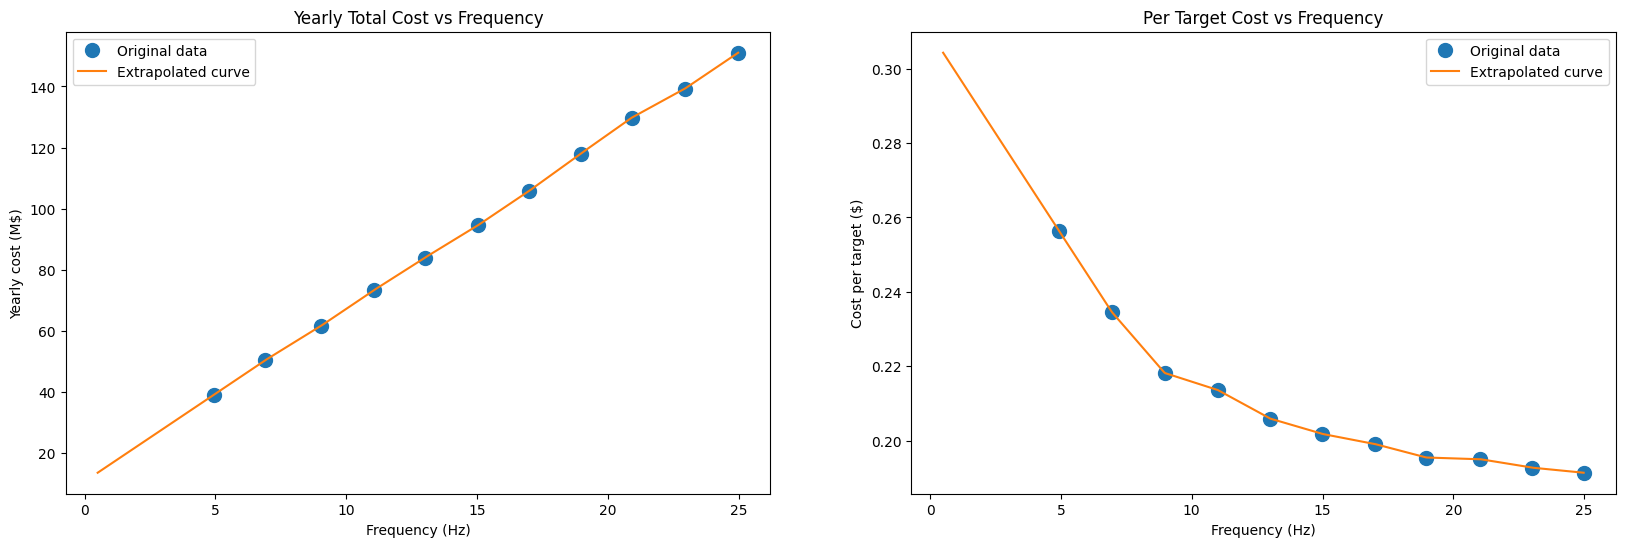

Copied /content/PyFECONS/IFE/Originals/CAS220108_IFE.tex to /content/PyFECONS/IFE/Modified/CAS220108_IFE.tex.
Replaced 'cvddiamondablatornomachines' with '286.4' in '/content/PyFECONS/IFE/Modified/CAS220108_IFE.tex'.
Replaced 'cvddiamondablatorfloorspacesqrft' with '46189.3' in '/content/PyFECONS/IFE/Modified/CAS220108_IFE.tex'.
Replaced 'cvddiamondablatorwipparts' with '30.7' in '/content/PyFECONS/IFE/Modified/CAS220108_IFE.tex'.
Replaced 'cvddiamondablatortccdollars' with '83.2' in '/content/PyFECONS/IFE/Modified/CAS220108_IFE.tex'.
Replaced 'cvddiamondablatorannualizedccdollarsperyear' with '6.4' in '/content/PyFECONS/IFE/Modified/CAS220108_IFE.tex'.
Replaced 'cvddiamondablatorconsumableselectricitymaint' with '38.5' in '/content/PyFECONS/IFE/Modified/CAS220108_IFE.tex'.
Replaced 'cvddiamondablatorpersonnelcostsdollarsperyear' with '7.2' in '/content/PyFECONS/IFE/Modified/CAS220108_IFE.tex'.
Replaced 'cvddiamondablatorcostpertarget' with '0.1' in '/content/PyFECONS/IFE/Modified/CAS2

In [18]:
#22.1.8 Target factory
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

#INPUT
freq=1 #[Hz]

LIFE_target_yield = 132 #MJ released per target from https://www.sciencedirect.com/science/article/abs/pii/S0920379613007357
syst_PRF = PNRL/LIFE_target_yield #required PRF to acheive target PNRL (assuming exact target design as specified)
learning_credit = 0.8 #learning credit multiplication factor

yearlytcost_PFR_coords = [
    [4.948453608247423, 39.160839160839174],
    [6.892488954344623, 50.349650349650375],
    [9.013254786450663, 61.53846153846155],
    [11.045655375552284, 73.28671328671331],
    [12.989690721649483, 83.91608391608395],
    [15.022091310751103, 94.54545454545456],
    [16.966126656848303, 105.73426573426576],
    [18.954344624447714, 118.04195804195807],
    [20.898379970544916, 129.79020979020981],
    [22.930780559646536, 139.30069930069934],
    [24.963181148748156, 151.04895104895107]
]

pertarget_PFR_coords = [
    [4.9327354260089695, 0.25636363636363635],
    [6.95067264573991, 0.23454545454545453],
    [8.968609865470853, 0.21818181818181814],
    [10.986547085201797, 0.21363636363636362],
    [13.004484304932737, 0.20590909090909087],
    [14.977578475336328, 0.20181818181818179],
    [16.99551569506727, 0.19909090909090907],
    [18.968609865470853, 0.19545454545454544],
    [21.031390134529147, 0.19499999999999998],
    [23.00448430493274, 0.1927272727272727],
    [24.97757847533633, 0.19136363636363635]
]

def interpolate_and_plot(coordinates1, coordinates2):
    # Function to interpolate and plot a single set of coordinates
    def interpolate_plot(ax, coordinates, title, ylabel):
        x = [coord[0] for coord in coordinates]
        y = [coord[1] for coord in coordinates]

        # Creating an interpolation function
        interpolation_function = interp1d(x, y, kind='linear', fill_value="extrapolate")

        # Generating new x values for interpolation and extrapolation
        x_new = np.linspace(0.5, max(x), num=500, endpoint=True)

        # Using the interpolation function to find new y values
        y_new = interpolation_function(x_new)

        # Plotting the original and interpolated points on the given axis
        ax.plot(x, y, 'o', label='Original data', markersize=10)
        ax.plot(x_new, y_new, '-', label='Extrapolated curve')
        ax.legend()
        ax.set_xlabel('Frequency (Hz)')
        ax.set_ylabel(ylabel)
        ax.set_title(title)

    # Creating a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    # Interpolating and plotting for the first set of coordinates
    interpolate_plot(ax1, coordinates1, 'Yearly Total Cost vs Frequency', 'Yearly cost (M$)')
    interpolate_function1 = interp1d([coord[0] for coord in coordinates1], [coord[1] for coord in coordinates1], kind='linear', fill_value="extrapolate")

    # Interpolating and plotting for the second set of coordinates
    interpolate_plot(ax2, coordinates2, 'Per Target Cost vs Frequency', 'Cost per target ($)')
    interpolate_function2 = interp1d([coord[0] for coord in coordinates2], [coord[1] for coord in coordinates2], kind='linear', fill_value="extrapolate")

    plt.show()
    fig.savefig(os.path.join(figures_directory, 'targetPFR.pdf'), bbox_inches='tight')

    # Returning the interpolation functions for both sets
    return interpolate_function1, interpolate_function2




target_factory_costs = {
    "CVD diamond ablator": {"no_machines": 250,
        "floorspace_sqrft": 40315,
        "wip_parts": 26769613,
        "tcc_dollars": 72627250,
        "annualized_cc_dollars_per_year": 5586712,
        "consumables_electricity_maint": 33617103,
        "personnel_costs_dollars_per_year": 6250000,
        "cost_per_target": 0.096
    },
    "DT Fill":{"no_machines": 57,
        "floorspace_sqrft": 1858,
        "wip_parts": 52,
        "tcc_dollars": 70553750,
        "annualized_cc_dollars_per_year": 5427212,
        "consumables_electricity_maint": 4120108,
        "personnel_costs_dollars_per_year": 1425000,
        "cost_per_target": 0.023
    },
    "Hohlraum press":{
        "no_machines": 4,
        "floorspace_sqrft": 680,
        "wip_parts": 4,
        "tcc_dollars": 3759140,
        "annualized_cc_dollars_per_year": 289165,
        "consumables_electricity_maint": 758791,
        "personnel_costs_dollars_per_year": 100000,
        "cost_per_target": 0.011
    },
    "Tent assy":{ "no_machines": 15,
        "floorspace_sqrft": 568,
        "wip_parts": 6448,
        "tcc_dollars": 1694905,
        "annualized_cc_dollars_per_year": 130377,
        "consumables_electricity_maint": 548766,
        "personnel_costs_dollars_per_year": 375000,
        "cost_per_target": 0.005
    },
     "Hohlraum-capsule assy":{
        "no_machines": 84,
        "floorspace_sqrft": 2016,
        "wip_parts": 78,
        "tcc_dollars": 2185376,
        "annualized_cc_dollars_per_year": 168106,
        "consumables_electricity_maint": 2542416,
        "personnel_costs_dollars_per_year": 2100000,
        "cost_per_target": 0.012
    },
    "LEH window attach":{
        "no_machines": 91,
        "floorspace_sqrft": 2919,
        "wip_parts": 91,
        "tcc_dollars": 90828500,
        "annualized_cc_dollars_per_year": 6986808,
        "consumables_electricity_maint": 3124288,
        "personnel_costs_dollars_per_year": 2275000,
        "cost_per_target": 0.025
    },
    "DT ice form":{
        "no_machines": 1,
        "floorspace_sqrft": 27,
        "wip_parts": 561600,
        "tcc_dollars": 2257455,
        "annualized_cc_dollars_per_year": 173650,
        "consumables_electricity_maint": 379143,
        "personnel_costs_dollars_per_year": 25000,
        "cost_per_target": 0.001
    },
     "Recover and recycle":{
        "no_machines": None,
        "floorspace_sqrft": None,
        "wip_parts": None,
        "tcc_dollars": None,
        "annualized_cc_dollars_per_year": None,
        "consumables_electricity_maint": None,
        "personnel_costs_dollars_per_year": None,
        "cost_per_target": 0
    },
    "Facility management costs":{
        "no_machines": None,
        "floorspace_sqrft": 2000,
        "wip_parts": None,
        "tcc_dollars": 500000,
        "annualized_cc_dollars_per_year": 38462,
        "consumables_electricity_maint": 70420,
        "personnel_costs_dollars_per_year": 6250000,
        "cost_per_target": 0.016
    },
    "Total process":{
        "no_machines": 502,
        "floorspace_sqrft": 50383,
        "wip_parts": 27337886,
        "tcc_dollars": 244406376,
        "annualized_cc_dollars_per_year": 18762029,
        "consumables_electricity_maint": 45161035,
        "personnel_costs_dollars_per_year": 18800000,
        "cost_per_target": 0.189
    },
    "Add material":{
        "no_machines": None,
        "floorspace_sqrft": None,
        "wip_parts": None,
        "tcc_dollars": None,
        "annualized_cc_dollars_per_year": None,
        "consumables_electricity_maint": None,
        "personnel_costs_dollars_per_year": None,
        "cost_per_target": 0.03213
    }
}

interpolated1, interpolated2 = interpolate_and_plot(yearlytcost_PFR_coords, pertarget_PFR_coords)

field_scaling_factors = {
    "no_machines": PNET/1000,
    "floorspace_sqrft": PNET/1000,
    "wip_parts": PNET/1000*1e-6,
    "tcc_dollars": PNET/1000*1e-6,
    "annualized_cc_dollars_per_year": PNET/1000*1e-6,
    "consumables_electricity_maint": PNET/1000*1e-6,
    "personnel_costs_dollars_per_year": PNET/1000*1e-6,
    "cost_per_target": PNET/1000*learning_credit
}


scaled_target_factory_costs = {}

for key, nested_dict in target_factory_costs.items():
    scaled_nested_dict = {}
    for field, value in nested_dict.items():
        scale_factor = field_scaling_factors.get(field, 1)  # Default to 1 if no scaling factor is defined
        if isinstance(value, (int, float)):
            scaled_nested_dict[field] = value * scale_factor
        else:
            scaled_nested_dict[field] = value  # Keep the original value if it's not numeric
    scaled_target_factory_costs[key] = scaled_nested_dict


total_annualized_cc = 0
total_consumables_electricity_maint = 0
total_personnel_costs = 0
total_target_costs = 0

# Iterate through each nested dictionary
for key, nested_dict in scaled_target_factory_costs.items():
    if "annualized_cc_dollars_per_year" in nested_dict and nested_dict["annualized_cc_dollars_per_year"] is not None:
        total_annualized_cc += nested_dict["annualized_cc_dollars_per_year"]

    if "consumables_electricity_maint" in nested_dict and nested_dict["consumables_electricity_maint"] is not None:
        total_consumables_electricity_maint += nested_dict["consumables_electricity_maint"]

    if "personnel_costs_dollars_per_year" in nested_dict and nested_dict["personnel_costs_dollars_per_year"] is not None:
        total_personnel_costs += nested_dict["personnel_costs_dollars_per_year"]


    if "cost_per_target" in nested_dict and nested_dict["cost_per_target"] is not None:
        total_personnel_costs += nested_dict["cost_per_target"]

tot_targets = freq*3.154e7
tot_capital_cost = scaled_target_factory_costs["Total process"]["tcc_dollars"]/1e6
C220108=tot_capital_cost

# Creating the new dictionary with placeholder variable names
placeholder_dict = {}
for parent_key, sub_dict in scaled_target_factory_costs.items():
    for sub_key, value in sub_dict.items():
        placeholder_key = parent_key.replace(" ", "").replace("-", "") + sub_key.replace("_", "")
        placeholder_dict[placeholder_key.lower()] = value


# Copying the .tex file
copy_file('CAS220108_IFE.tex')
# Overwriting the placeholders in the .tex file
for var_name, var_value in placeholder_dict.items():
    if var_value is not None:
      overwrite_variable('CAS220108_IFE.tex', var_name, round(var_value, 1))
    else:
        overwrite_variable('CAS220108_IFE.tex', var_name, var_value)
overwrite_variable('CAS220108_IFE.tex', 'C220108', round(C220108))

In [19]:
#22.1.9 Direct Energy Converter
import math
#Subsystem costs
de_costs = {
    "expandertank": 16,
    "expandercoilandneutrontrapcoil": 33,
    "convertoegatevalve": 0.1,
    "neutrontrapshielding": 1,
    "vacuumsystem": 16,
    "gridsystem": 27,
    "heatcollectionsystem": 6,
    "electricaleqpmt": 13,
    "costperunit": 112,
    "totaldeunitcost": 447,
    "engineering15percent": 67,
    "contingency15percent": 77,
    "totaldecost": 591
}

if NOAK =="y":
  de_costs["contingency15percent"] = 0

def de_scaling(syst_power, flux_lim, input_dict):
    scaled_dict = {}
    for key, value in input_dict.items():
        scaled_value = value * syst_power * (1 / math.sqrt(flux_lim)) ** 3
        scaled_dict[key] = scaled_value
    return scaled_dict

scaled_de_costs=de_scaling(1, 2, de_costs)
C220109 = scaled_de_costs['totaldecost']
C220109=0
"""
WRITE TO LATEX
"""
copy_file('CAS220109.tex')
# Iterate over the scaled_de_costs dictionary
for key, value in scaled_de_costs.items():
    # replace each value in the .tex file
    overwrite_variable('CAS220109.tex', key, round(value, 1))
overwrite_variable('CAS220109.tex', 'C220109', round(C220109))

Copied /content/PyFECONS/IFE/Originals/CAS220109.tex to /content/PyFECONS/IFE/Modified/CAS220109.tex.
Replaced 'expandertank' with '5.7' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'expandercoilandneutrontrapcoil' with '11.7' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'convertoegatevalve' with '0.0' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'neutrontrapshielding' with '0.4' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'vacuumsystem' with '5.7' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'gridsystem' with '9.5' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'heatcollectionsystem' with '2.1' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'electricaleqpmt' with '4.6' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'costperunit' with '39.6' in '/content/PyFECONS/IFE/Modified/CAS220109.tex'.
Replaced 'totaldeunitcost' with '158.0' in '/content/PyFECONS/IFE/Modified/CAS2201

In [20]:
#Cost Category 22.1.11 Installation costs

# Define labor rate
lr = 1600 / 1e6  # 1600 dollars per day for skilled labor

# Calculations
constructionworker = 20 * axis_ir / 4
C_22_1_11_in = NMOD * constructionTime * (lr * 20 * 300)
C_22_1_11_1_in = NMOD * ((lr * 200 * constructionworker) + 0)  # 22.1 first wall blanket
C_22_1_11_2_in = NMOD * ((lr * 150 * constructionworker) + 0)  # 22.2 shield
C_22_1_11_3_in = NMOD * ((lr * 100 * constructionworker) + 0)  # lasers
C_22_1_11_4_in = NMOD * ((lr * 30 * constructionworker) + 0)  # supplementary heating
C_22_1_11_5_in = NMOD * ((lr * 60 * constructionworker) + 0)  # primary structure
C_22_1_11_6_in = NMOD * ((lr * 200 * constructionworker) + 0)  # vacuum system
C_22_1_11_7_in = NMOD * ((lr * 400 * constructionworker) + 0)  # power supplies
C_22_1_11_8_in = 0  # guns or divertor
C_22_1_11_9_in = NMOD * ((lr * 200 * constructionworker) + 0)   # direct energy converter
C_22_1_11_10_in = 0  # ECRH

# Total cost calculations
C220111 = (C_22_1_11_in + C_22_1_11_1_in + C_22_1_11_2_in + C_22_1_11_3_in + C_22_1_11_4_in + C_22_1_11_5_in + C_22_1_11_6_in + C_22_1_11_7_in + C_22_1_11_8_in + C_22_1_11_9_in + C_22_1_11_10_in)

copy_file('CAS220111.tex')
overwrite_variable('CAS220111.tex', 'C220112', round(C220111))
overwrite_variable('CAS220111.tex', 'constructionTime', constructionTime)

Copied /content/PyFECONS/IFE/Originals/CAS220111.tex to /content/PyFECONS/IFE/Modified/CAS220111.tex.
Replaced 'C220112' with '58' in '/content/PyFECONS/IFE/Modified/CAS220111.tex'.
Replaced 'constructionTime' with '6' in '/content/PyFECONS/IFE/Modified/CAS220111.tex'.


In [21]:
#Cost category 22.1.19 Scheduled Replacement Cost
C220119=0

copy_file('CAS220119.tex')
overwrite_variable('CAS220119.tex', 'C220119', round(C220119))

Copied /content/PyFECONS/IFE/Originals/CAS220119.tex to /content/PyFECONS/IFE/Modified/CAS220119.tex.
Replaced 'C220119' with '0' in '/content/PyFECONS/IFE/Modified/CAS220119.tex'.


In [22]:
#Cost category 22.1 total
C220100 = C220101 + C220102 + C220103 + C220104 + C220105 + C220106 + C220107 +C220108 + C220109 + C220111 +C220119

In [23]:
#MAIN AND SECONDARY COOLANT Cost Category 22.2
NMOD=1

#C_22_2_1  = 233.9 * (PTH/3500)^0.55; 	#Li(f), PbLi, He:                %Primary coolant(i):
C220201  = 268.5  * (NMOD * PTH/3500) * 1.71 #am assuming a linear scaling	%Li(f), PbLi, He:
#Primary coolant(i):  1.85 is due to inflation%the CPI scaling of 1.71 comes from:
#https://www.bls.gov/data/inflation_calculator.htm scaled relative to 1992 dollars (despite 2003 publication date)
C220201 = 166 * (NMOD * PNET/1000)  #this is the Sheffield cost for a 1GWe system
#C_22_2_1  = 75.0 * (PTH/3500)^0.55   	#OC, H2O(g)
C220202 = 40.6 * (PTH/3500)**0.55     #Intermediate coolant system
C220203  = 0
#75.0 * (PTH/3500)^0.55      Secondary coolant system

C220200=  round(C220201 + C220202 + C220203,1)             #Main heat-transfer system (NSSS):

copy_file('CAS220200_DT.tex')
overwrite_variable('CAS220200_DT.tex', 'C220200', round(C220200))
overwrite_variable('CAS220200_DT.tex', 'C220201', round(C220201))
overwrite_variable('CAS220200_DT.tex', 'C220202', round(C220202))
overwrite_variable('CAS220200_DT.tex', 'C220203', round(C220203))
overwrite_variable('CAS220200_DT.tex', 'primaryC', primaryC)
overwrite_variable('CAS220200_DT.tex', 'secondaryC', secondaryC)

Copied /content/PyFECONS/IFE/Originals/CAS220200_DT.tex to /content/PyFECONS/IFE/Modified/CAS220200_DT.tex.
Replaced 'C220200' with '226' in '/content/PyFECONS/IFE/Modified/CAS220200_DT.tex'.
Replaced 'C220201' with '190' in '/content/PyFECONS/IFE/Modified/CAS220200_DT.tex'.
Replaced 'C220202' with '35' in '/content/PyFECONS/IFE/Modified/CAS220200_DT.tex'.
Replaced 'C220203' with '0' in '/content/PyFECONS/IFE/Modified/CAS220200_DT.tex'.
Replaced 'primaryC' with 'Lead Lithium (PbLi)' in '/content/PyFECONS/IFE/Modified/CAS220200_DT.tex'.
Replaced 'secondaryC' with 'water' in '/content/PyFECONS/IFE/Modified/CAS220200_DT.tex'.


In [24]:
#Cost Category 22.3  Auxiliary cooling


C220300    = round(1.10 * 1e-3 * NMOD * PTH * 2.02,1)          #Auxiliary cooling systems %the CPI scaling of 2.02 comes from: https://www.bls.gov/data/inflation_calculator.htm scaled relative to 1992 dollars (despite 2003 publication date)

copy_file('CAS220300.tex')
overwrite_variable('CAS220300.tex', 'C220300', round(C220300,1))

Copied /content/PyFECONS/IFE/Originals/CAS220300.tex to /content/PyFECONS/IFE/Modified/CAS220300.tex.
Replaced 'C220300' with '6.0' in '/content/PyFECONS/IFE/Modified/CAS220300.tex'.


In [25]:
#Cost Category 22.4 Radwaste

C220400    = round(1.96 * 1e-3 * PTH * 2.02  ,1)     	#Radioactive waste treatment %the CPI scaling of 1.96 comes from: https://www.bls.gov/data/inflation_calculator.htm scaled relative to 1992 dollars (despite 2003 publication date)

copy_file('CAS220400.tex')
overwrite_variable('CAS220400.tex', 'C220400', C220400)

Copied /content/PyFECONS/IFE/Originals/CAS220400.tex to /content/PyFECONS/IFE/Modified/CAS220400.tex.
Replaced 'C220400' with '10.8' in '/content/PyFECONS/IFE/Modified/CAS220400.tex'.


In [26]:
#Cost Category 22.5 Fuel Handling and Storage


inflation = 1.43
C2205010ITER = 20.465*inflation
C2205020ITER = 7*inflation
C2205030ITER = 22.511*inflation
C2205040ITER = 9.76*inflation
C2205050ITER = 22.826*inflation
C2205060ITER = 47.542*inflation
C22050ITER = C2205010ITER+C2205020ITER+C2205030ITER+C2205040ITER+C2205050ITER+C2205060ITER #ITER inflation cost


lcredit = 0.8 #%learning curve
ltoak = 10 ** (math.log10(lcredit) / math.log10(2))


C220501 = C2205010ITER*ltoak
C220502 = C2205020ITER*ltoak
C220503 = C2205030ITER*ltoak
C220504 = C2205040ITER*ltoak
C220505 = C2205050ITER*ltoak
C220506 = C2205060ITER*ltoak
C220500 = C220501+C220502+C220503+C220504+C220505+C220506 #ITER inflation cost

variable_dictionary = {
    "lcredit": lcredit, "ltoak": ltoak, "C2205010ITER": C2205010ITER, "C2205020ITER": C2205020ITER,
    "C2205030ITER": C2205030ITER, "C2205040ITER": C2205040ITER, "C2205050ITER": C2205050ITER,
    "C2205060ITER": C2205060ITER, "C22050ITER": C22050ITER, "C220501": C220501, "C220502": C220502,
    "C220503": C220503, "C220504": C220504, "C220505": C220505, "C220506": C220506, "C220500": C220500
}

# Copying the .tex file
copy_file('CAS220500_DT.tex')
# Overwriting the placeholders in the .tex file
for var_name, var_value in variable_dictionary.items():
    overwrite_variable('CAS220500_DT.tex', var_name, round(var_value,1))

Copied /content/PyFECONS/IFE/Originals/CAS220500_DT.tex to /content/PyFECONS/IFE/Modified/CAS220500_DT.tex.
Replaced 'lcredit' with '0.8' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'ltoak' with '0.5' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C2205010ITER' with '29.3' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C2205020ITER' with '10.0' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C2205030ITER' with '32.2' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C2205040ITER' with '14.0' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C2205050ITER' with '32.6' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C2205060ITER' with '68.0' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C22050ITER' with '186.0' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C220501' with '13.9' in '/content/PyFECONS/IFE/Modified/CAS220500_DT.tex'.
Replaced 'C2

In [27]:
#Cost Category 22.6 Other Reactor Plant Equipment


C220600 = round(11.5*(PNET/1000)**(0.8),1) #from waganer

copy_file('CAS220600.tex')
overwrite_variable('CAS220600.tex', 'C220600', round(C220600))

Copied /content/PyFECONS/IFE/Originals/CAS220600.tex to /content/PyFECONS/IFE/Modified/CAS220600.tex.
Replaced 'C220600' with '13' in '/content/PyFECONS/IFE/Modified/CAS220600.tex'.


In [28]:
#Cost Category 22.7 Instrumentation and Control

# 22.07.00.00    instrumentation & control(i&c)
C220700 = 85

copy_file('CAS220700.tex')
overwrite_variable('CAS220700.tex', 'C220700', round(C220700))

Copied /content/PyFECONS/IFE/Originals/CAS220700.tex to /content/PyFECONS/IFE/Modified/CAS220700.tex.
Replaced 'C220700' with '85' in '/content/PyFECONS/IFE/Modified/CAS220700.tex'.


In [29]:
#Reactor Plant Equipment (RPE) total
C220000 = C220100 + C220200 + C220300 + C220400 + C220500 + C220600 + C220700
copy_file('CAS220000.tex')
overwrite_variable('CAS220000.tex', 'C220000', C220000)

variables_to_overwrite = {'BFSrho': materials['BFS']['rho'], 'BFScraw': materials['BFS']['c_raw'], 'BFSm': materials['BFS']['m'],
    'FSrho': materials['FS']['rho'], 'FScraw': materials['FS']['c_raw'], 'FSm': materials['FS']['m'],
    'FSsigma': materials['FS']['sigma'],
    'Li4SiO4rho': materials['Li4SiO4']['rho'], 'Li4SiO4craw': materials['Li4SiO4']['c_raw'],
    'Li4SiO4m': materials['Li4SiO4']['m'], 'FLiBerho': materials['FLiBe']['rho'], 'FLiBec': materials['FLiBe']['c'],
    'Wrho': materials['W']['rho'], 'Wcraw': materials['W']['c_raw'], 'Wm': materials['W']['m'],
    'SiCrho': materials['SiC']['rho'], 'SiCcraw': materials['SiC']['c_raw'], 'SiCm': materials['SiC']['m'],
    'Inconelrho': materials['Inconel']['rho'], 'Inconelcraw': materials['Inconel']['c_raw'], 'Inconelm': materials['Inconel']['m'],
    'Curho': materials['Cu']['rho'], 'Cucraw': materials['Cu']['c_raw'], 'Cum': materials['Cu']['m'],
    'Polyimiderho': materials['Polyimide']['rho'], 'Polyimidecraw': materials['Polyimide']['c_raw'], 'Polyimidem': materials['Polyimide']['m'],
    'YBCOrho': materials['YBCO']['rho'], 'YBCOc': materials['YBCO']['c'], 'Concreterho': materials['Concrete']['rho'],
    'Concretecraw': materials['Concrete']['c_raw'], 'Concretem': materials['Concrete']['m'],
    'SS316rho': materials['SS316']['rho'], 'SS316craw': materials['SS316']['c_raw'], 'SS316m': materials['SS316']['m'],
    'SS316sigma': materials['SS316']['sigma'], 'Nb3Snc': materials['Nb3Sn']['c'], 'Incoloyrho': materials['Incoloy']['rho'],
    'Incoloycraw': materials['Incoloy']['c_raw'], 'Incoloym': materials['Incoloy']['m'],'Pbrho': materials['Pb']['rho'], 'Pbcraw': materials['Pb']['c_raw'],
    'Pbm': materials['Pb']['m'],"PbLirho":materials["PbLi"]["rho"],"PbLic":materials["PbLi"]["c"],'Lirho': materials['Li']['rho'], 'Licraw': materials['Li']['c_raw'], 'Lim': materials['Li']['m']
}


for var_name, var_value in variables_to_overwrite.items():
    overwrite_variable('CAS220000.tex', var_name, round(var_value,2))

Copied /content/PyFECONS/IFE/Originals/CAS220000.tex to /content/PyFECONS/IFE/Modified/CAS220000.tex.
Replaced 'C220000' with '3679.12843853315' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'BFSrho' with '7800' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'BFScraw' with '30' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'BFSm' with '2' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'FSrho' with '7470' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'FScraw' with '10' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'FSm' with '3' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'FSsigma' with '450' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'Li4SiO4rho' with '2390' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'Li4SiO4craw' with '1' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Replaced 'Li4SiO4m' with '2' in '/content/PyFECONS/IFE/Modified/CAS220000.tex'.
Repl

In [30]:
#Cost Category 23 Turbine Plant Equipment


C230000=round(NMOD * PET * 0.219 *1.15,1)

copy_file('CAS230000.tex')
overwrite_variable('CAS230000.tex', 'C230000', round(C230000))

Copied /content/PyFECONS/IFE/Originals/CAS230000.tex to /content/PyFECONS/IFE/Modified/CAS230000.tex.
Replaced 'C230000' with '315' in '/content/PyFECONS/IFE/Modified/CAS230000.tex'.


In [31]:
#Cost Category 24 Electric Plant Equipment

C240000= round(NMOD * PET * 0.054 * 1.15,1)

copy_file('CAS240000.tex')
overwrite_variable('CAS240000.tex', 'C240000', round(C240000))

Copied /content/PyFECONS/IFE/Originals/CAS240000.tex to /content/PyFECONS/IFE/Modified/CAS240000.tex.
Replaced 'C240000' with '78' in '/content/PyFECONS/IFE/Modified/CAS240000.tex'.


In [32]:
#Cost Category 25 Miscellaneous Plant Equipment

C250000  = round( NMOD* PET  * 0.038 * 1.15,1)   #factor of 1.15 obtained from escalating relative to 2019 $

copy_file('CAS250000.tex')
overwrite_variable('CAS250000.tex', 'C250000', round(C250000))

Copied /content/PyFECONS/IFE/Originals/CAS250000.tex to /content/PyFECONS/IFE/Modified/CAS250000.tex.
Replaced 'C250000' with '55' in '/content/PyFECONS/IFE/Modified/CAS250000.tex'.


In [33]:
#Cost Category 26 Heat Rejection

C260000 = round(NMOD * PNET * 0.107 * 1.15,1) #heat rejection scaled as NET electric power escalated relative to 2019 dollars to 2026 dollars

copy_file('CAS260000.tex')
overwrite_variable('CAS260000.tex', 'C260000', round(C260000))

Copied /content/PyFECONS/IFE/Originals/CAS260000.tex to /content/PyFECONS/IFE/Modified/CAS260000.tex.
Replaced 'C260000' with '141' in '/content/PyFECONS/IFE/Modified/CAS260000.tex'.


In [34]:
#Cost Category 27 Special Materials

# Select the coolant and calculate C270100
MLM = (firstwall_vol) * materials['Pb']['rho']/1000


if primaryC == 'FLiBe':
    C270100 = 1000 * 2130 * materials['FLiBe']['c'] / 1e6
elif primaryC == 'Lead Lithium (PbLi)':
    f_6Li = 0.1
    FPCPPFb = 0.9
    C270100 = (materials['Pb']['c_raw'] * FPCPPFb * MLM * 1000 + materials['Li']['c_raw'] * f_6Li * MLM * 1000) / 1e6
elif primaryC == 'Lithium (Li)':
    C270100 = 1000 * 2130 * 50 / 1e6
elif primaryC == 'other eutectic salt':
    C270100 = 1000 * 2130 * 50 / 1e6
elif primaryC == 'helium':
    C270100 = 1000 * 2.13 * 50 / 1e6
elif primaryC == 'dual coolant: PbLi and He':
    C270100 = 1000 * 2.13 * 50 / 1e6
elif primaryC == 'water':
    C270100 = 1000 * 1000 * 1 / 1e6

# Additional calculations
C_27_4 = 0.41 * 1.71  # Other
C_27_5 = 0.21 * 1.71  # Reactor-building cover gas
C270000 = round(C270100 + C_27_4 + C_27_5,1)


C270200 = 0
C270300 = 0

copy_file('CAS270000.tex')
overwrite_variable('CAS270000.tex', 'C270000', round(C270000))
overwrite_variable('CAS270000.tex', 'C270100', round(C270100))
overwrite_variable('CAS270000.tex', 'C270200', round(C270200))
overwrite_variable('CAS270000.tex', 'C270300', round(C270300))
overwrite_variable('CAS270000.tex', 'primaryC', primaryC)
overwrite_variable('CAS270000.tex', 'primaryV', round(firstwall_vol))

Copied /content/PyFECONS/IFE/Originals/CAS270000.tex to /content/PyFECONS/IFE/Modified/CAS270000.tex.
Replaced 'C270000' with '1' in '/content/PyFECONS/IFE/Modified/CAS270000.tex'.
Replaced 'C270100' with '0' in '/content/PyFECONS/IFE/Modified/CAS270000.tex'.
Replaced 'C270200' with '0' in '/content/PyFECONS/IFE/Modified/CAS270000.tex'.
Replaced 'C270300' with '0' in '/content/PyFECONS/IFE/Modified/CAS270000.tex'.
Replaced 'primaryC' with 'Lead Lithium (PbLi)' in '/content/PyFECONS/IFE/Modified/CAS270000.tex'.
Replaced 'primaryV' with '5' in '/content/PyFECONS/IFE/Modified/CAS270000.tex'.


In [35]:
#cost category 28 Digital Twin

C280000=5

copy_file('CAS280000.tex')
overwrite_variable('CAS280000.tex', 'C280000', round(C280000))

Copied /content/PyFECONS/IFE/Originals/CAS280000.tex to /content/PyFECONS/IFE/Modified/CAS280000.tex.
Replaced 'C280000' with '5' in '/content/PyFECONS/IFE/Modified/CAS280000.tex'.


In [36]:
#Cost Category 29 Contingency
if NOAK == "y":
  C290000 = 0
else:
  C290000= 0.1 * (C210000+C210000 + C220000 + C230000 + C240000 + C250000 + C260000 + C270000 + C280000 + C280000)


copy_file('CAS290000.tex')
overwrite_variable('CAS290000.tex', 'C290000', round(C290000))

Copied /content/PyFECONS/IFE/Originals/CAS290000.tex to /content/PyFECONS/IFE/Modified/CAS290000.tex.
Replaced 'C290000' with '0' in '/content/PyFECONS/IFE/Modified/CAS290000.tex'.


In [37]:
C200000 = C210000+C210000 + C220000 + C230000 + C240000 + C250000 + C260000 + C270000 + C280000 + C280000 + C290000
copy_file('CAS200000.tex')
overwrite_variable('CAS200000.tex', 'C200000', round(C200000))

Copied /content/PyFECONS/IFE/Originals/CAS200000.tex to /content/PyFECONS/IFE/Modified/CAS200000.tex.
Replaced 'C200000' with '6068' in '/content/PyFECONS/IFE/Modified/CAS200000.tex'.


# Indirect Costs

In [38]:
#Cost Category 30 Capitalized Indirect Service Costs (CISC)

# Define LSA
LSA = 2

# Indirect Cost Factors for different LSA levels
fac_91 = [0.1130, 0.1200, 0.1280, 0.1510]  # x TDC [90]
fac_92 = [0.0520, 0.0520, 0.0520, 0.0520]  # x TDC [90]
fac_93 = [0.0520, 0.0600, 0.0640, 0.0870]  # x TDC [90]
fac_94 = [0.1826, 0.1848, 0.1866, 0.1935]  # applies only to C90, x TDC [90+91+92+93]
fac_95 = [0.0000, 0.0000, 0.0000, 0.0000]  # x TDC [90+91+92+93+94]
fac_96 = [0.2050, 0.2391, 0.2565, 0.2808]  # applied only to C90, x TDC [90+91+92+93+94]
fac_97 = [0.2651, 0.2736, 0.2787, 0.2915]  # applied only to C90, x TDC [90+91+92+93+94+95+96]
fac_98 = [0.0000, 0.0000, 0.0000, 0.0000]  # x TDC [90+91+92+93+94+95+96]


#Cost Category 31 – Field Indirect Costs - previously Cost Category 93

C310000LSA = fac_93[LSA - 1] * C200000
#0.060 * C_90; %NMOD*(/1e6)/A_power * A_C_93 #Field Office Engineering and Services  Table 3.2-VII of Ref. [1]

C310000 = (PNET/150)**-0.5 * PNET * 0.02 * constructionTime

#Cost Category 32  – Construction Supervision - previously Cost Category 91

C320000LSA = fac_91[LSA - 1] * C200000
C320000 = (PNET/150)**-0.5 * PNET * 0.05 * constructionTime #this takes the 316$/kW and divides by 6 to obtain a cost per year of 0.053$/MW and applies to PE, which is the net electric.  There are arguments that this should be applied to the gross electric, if we consider demonstration plants, but this code is not set up for FOAK currently.

#Cost Category 33 – Commissioning and Start-up Costs

#Cost Category 34 – Demonstration Test Run

#Cost Category 35 – Design Services Offsite

C350000 = (PNET/150)**-0.5 * PNET * 0.03 * constructionTime

C350000LSA = fac_92[LSA - 1] * C200000
#0.052 * C_90; %NMOD*(/1e6)/A_power * A_C_92; %Home Office Engineering and Services  Table 3.2-VII of Ref. [1]

C300000=C310000+C320000+C350000

copy_file('CAS300000.tex')
overwrite_variable('CAS300000.tex', 'constructionTime', constructionTime)
overwrite_variable('CAS300000.tex', 'C300000', round(C300000))
overwrite_variable('CAS300000.tex', 'C320000', round(C320000))
overwrite_variable('CAS300000.tex', 'C310000LSA', round(C310000LSA))
overwrite_variable('CAS300000.tex', 'C310000', round(C310000))
overwrite_variable('CAS300000.tex', 'C350000LSA', round(C350000LSA))
overwrite_variable('CAS300000.tex', 'C350000', round(C350000))

Copied /content/PyFECONS/IFE/Originals/CAS300000.tex to /content/PyFECONS/IFE/Modified/CAS300000.tex.
Replaced 'constructionTime' with '6' in '/content/PyFECONS/IFE/Modified/CAS300000.tex'.
Replaced 'C300000' with '249' in '/content/PyFECONS/IFE/Modified/CAS300000.tex'.
Replaced 'C320000' with '124' in '/content/PyFECONS/IFE/Modified/CAS300000.tex'.
Replaced 'C310000LSA' with '364' in '/content/PyFECONS/IFE/Modified/CAS300000.tex'.
Replaced 'C310000' with '50' in '/content/PyFECONS/IFE/Modified/CAS300000.tex'.
Replaced 'C350000LSA' with '316' in '/content/PyFECONS/IFE/Modified/CAS300000.tex'.
Replaced 'C350000' with '75' in '/content/PyFECONS/IFE/Modified/CAS300000.tex'.


In [39]:
#Cost Category 40 Capitalized Owner’s Cost (COC)

C400000LSA = fac_91[LSA - 1] * C200000

C400000 =C400000LSA
#Cost Category 41 – Staff Recruitment and Training

C410000=0

#Cost Category 42 – Staff Housing

C420000=0

#Cost Category 43 – Staff Salary-Related Costs

C430000 = 0

#Cost Category 44 – Other Owner’s Costs

C440000 = 0

#C400000 = C410000 + C420000 + C430000 + C440000

copy_file('CAS400000.tex')
overwrite_variable('CAS400000.tex', 'C400000LSA', round(C400000LSA))
overwrite_variable('CAS400000.tex', 'C400000', round(C400000))


Copied /content/PyFECONS/IFE/Originals/CAS400000.tex to /content/PyFECONS/IFE/Modified/CAS400000.tex.
Replaced 'C400000LSA' with '728' in '/content/PyFECONS/IFE/Modified/CAS400000.tex'.
Replaced 'C400000' with '728' in '/content/PyFECONS/IFE/Modified/CAS400000.tex'.


In [40]:
#Cost Category 50 Capitalized Supplementary Costs (CSC)


#Cost Category 51 – Shipping and Transportation Costs

C510000 = 8

#Cost Category 52 – Spare Parts

C520000 = 0.1 * (C230000 + C240000 + C250000 + C260000 + C270000 + C280000)

#Cost Category 53 – Taxes

C530000 = 100

#Cost Category 54 – Insurance

C540000 = 1

#Cost Category 55 – Initial Fuel Load

#$22 M to $34 M (2016 USD) for a standard 150 MWe FPP.

C550000 = PNET/150 * 34

#Cost Category 58 – Decommissioning Costs

C580000 = 200

#Cost Category 59 – Contingency on Supplementary Costs


if NOAK == "y":
  C590000=0
else:
  C590000 = 0.1 * (C580000 + C550000 + C540000 + C530000 + C520000 + C510000)


C500000 = C510000 + C520000 + C530000 + C540000 + C550000 + C580000 + C590000
''
copy_file('CAS500000.tex')
overwrite_variable('CAS500000.tex', 'C500000', round(C500000))
overwrite_variable('CAS500000.tex', 'C510000', round(C510000))
overwrite_variable('CAS500000.tex', 'C520000', round(C520000))
overwrite_variable('CAS500000.tex', 'C530000', round(C530000))
overwrite_variable('CAS500000.tex', 'C540000', round(C540000))
overwrite_variable('CAS500000.tex', 'C550000', round(C550000))
overwrite_variable('CAS500000.tex', 'C580000', round(C580000))
overwrite_variable('CAS500000.tex', 'C590000', round(C590000))

Copied /content/PyFECONS/IFE/Originals/CAS500000.tex to /content/PyFECONS/IFE/Modified/CAS500000.tex.
Replaced 'C500000' with '628' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.
Replaced 'C510000' with '8' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.
Replaced 'C520000' with '60' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.
Replaced 'C530000' with '100' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.
Replaced 'C540000' with '1' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.
Replaced 'C550000' with '260' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.
Replaced 'C580000' with '200' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.
Replaced 'C590000' with '0' in '/content/PyFECONS/IFE/Modified/CAS500000.tex'.


In [41]:
#Cost Category 60 Capitalized Financial Costs (CFC)

A_C_98 = 115
A_power = 1000

#Cost Category 61 – Escalation - formerly Cost Category 98: Escalation During Construction
C610000 = NMOD*(PNRL)/A_power * A_C_98 #Escalation during Construction (EDC) Table 3.2-X of Ref. [1]



# Cost Category 63 – Interest During Construction (IDC) formerly cost category 97
#for inflation rate = 0.05/y (cf. ARIES) and 0.02/y (lower and more modern).  The 0.05/y values check with Table 2.2-XVII p. 2-59 of the ARIES-II/IV report.
#Construction lead time is varied between 3 and 12 years. STARFIRE (with a published schedule) and ARIES used 6 years, which could be considered optimistic for a (big) tokamak.  We might be able to defend a lower base time for the smaller ARPA-E cases invoking factory fabrication and modularity (already assumed by STARFIRE).
#Your calculations so far have used the 6-yr f_IDC for 0.05/y inflation rate for Acct. 97; a sensitivity of TCC as a function of construction lead time is what we had in mind.
#f_EDC for constant-dollar costing is zero.  Nominal- (then-current dollar) costing includes f_EDC in Acct. 98.
#I am a bit surprised that the f_IDC for 0.02/y is slightly larger than the corresponding 0.05/y value.
#f_IDC - Interest During Construction for constant dollars
#f_EDC - Escalation During Construction
#a sensitivity of TCC as a function of construction lead time is what we had in mind

#yinf=  0.0500/y
#          			f_IDC(97)   	f_EDC(98)
#  con lead 	constant 	nominal 	nominal
#   3 		0.0863  	0.1624  	0.0951
#   4  		0.1118  	0.2119  	0.1394
#   5  		0.1381  	0.2637  	0.1887
#   6  		0.1652  	0.3178  	0.2436    <<<<
#   7  		0.1931  	0.3743  	0.3045
#   8  		0.2219  	0.4332  	0.3719
#   9  		0.2515  	0.4948  	0.4466
#  10  		0.2821  	0.5591  	0.5291
#  11  		0.3136  	0.6263  	0.6201
#  12  		0.3460  	0.6964  	0.7206

yearsconstr = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12];
costfac90 = [0.0863, 0.1118, 0.1381, 0.1652, 0.1931, 0.2219, 0.2515, 0.2821, 0.3136, 0.3460];

# yinf=  0.0200/y
#          f_IDC(97)   f_EDC(98)
#     constant nominal nominal
#   3  0.0863  0.1637  0.0376
#   4  0.1118  0.2144  0.0546
#   5  0.1381  0.2678  0.0733
#   6  0.1652  0.3239  0.0938
#   7  0.1931  0.3829  0.1162
#   8  0.2219  0.4450  0.1407
#   9  0.2515  0.5104  0.1675
#  10  0.2821  0.5792  0.1968
#  11  0.3136  0.6516  0.2288
#  12  0.3460  0.7279  0.2637

C630000LSA = fac_97[LSA - 1] * C200000

#C_97_sens = costfac90 * (C_90 + C_96 + C_94 + C_93 + C_92 + C_91);
#(/1e6)/A_power * A_C_97; %Interest during Construction (IDC)  Table 3.2-X of Ref. [1]

C630000 = PNET * 0.099 * constructionTime


C600000 = C630000 + C610000
copy_file('CAS600000.tex')
overwrite_variable('CAS600000.tex', 'C600000', round(C600000))
overwrite_variable('CAS600000.tex', 'C610000', round(C610000))
overwrite_variable('CAS600000.tex', 'C630000LSA', round(C630000LSA))
overwrite_variable('CAS600000.tex', 'C630000', round(C630000))


Copied /content/PyFECONS/IFE/Originals/CAS600000.tex to /content/PyFECONS/IFE/Modified/CAS600000.tex.
Replaced 'C600000' with '968' in '/content/PyFECONS/IFE/Modified/CAS600000.tex'.
Replaced 'C610000' with '288' in '/content/PyFECONS/IFE/Modified/CAS600000.tex'.
Replaced 'C630000LSA' with '1660' in '/content/PyFECONS/IFE/Modified/CAS600000.tex'.
Replaced 'C630000' with '681' in '/content/PyFECONS/IFE/Modified/CAS600000.tex'.


In [42]:
#Total Capital costs 99

C990000 = C100000 + C200000+ C300000 + C400000 + C500000 + C600000

In [43]:
#Cost Category  70 Annualized O&M Cost (AOC)

C_OM = 60 * PNET * 1000

#C750000 = 0.1 * (C220000) scheduled replacement costs

C700000 = C_OM/1e6 #+ C750000

copy_file('CAS700000.tex')
overwrite_variable('CAS700000.tex', 'C700000', round(C700000))
#overwrite_variable('CAS700000.tex', 'C750000', round(C750000))

Copied /content/PyFECONS/IFE/Originals/CAS700000.tex to /content/PyFECONS/IFE/Modified/CAS700000.tex.
Replaced 'C700000' with '69' in '/content/PyFECONS/IFE/Modified/CAS700000.tex'.


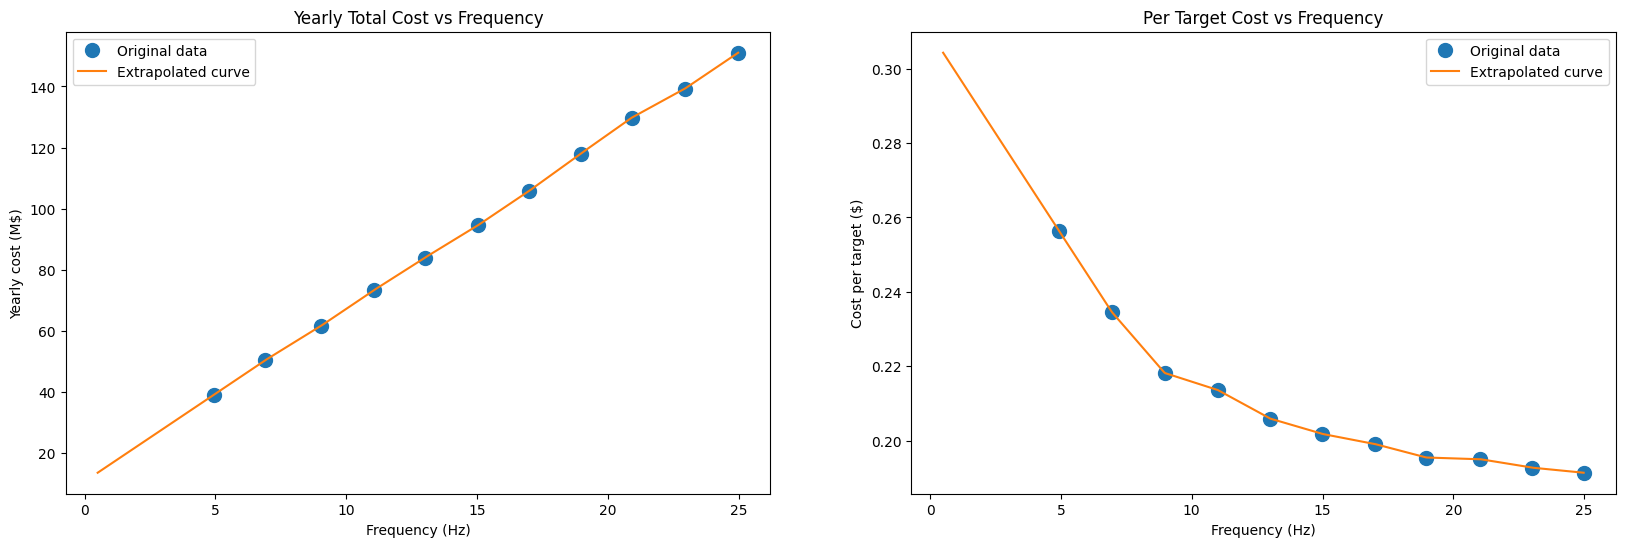

Copied /content/PyFECONS/IFE/Originals/CAS800000_DT.tex to /content/PyFECONS/IFE/Modified/CAS800000_DT.tex.
Replaced 'C800000' with '16' in '/content/PyFECONS/IFE/Modified/CAS800000_DT.tex'.


In [44]:
#Cost Category 80: Annualized Fuel Cost (AFC)
#Simple interpolation of yearly total target cost from interpolated grpah 2 below. See 22.1.8 for more.
C800000 = interpolate_and_plot(yearlytcost_PFR_coords, pertarget_PFR_coords)[0](freq).item()

copy_file('CAS800000_DT.tex')
overwrite_variable('CAS800000_DT.tex', 'C800000', round(C800000))

In [45]:
#Cost Category 90: Annualized Financial Costs (AFC)

f_cr = 0.09   #Capital return factor
C900000= f_cr * C990000

copy_file('CAS900000.tex')
overwrite_variable('CAS900000.tex', 'C900000', round(C900000))

Copied /content/PyFECONS/IFE/Originals/CAS900000.tex to /content/PyFECONS/IFE/Modified/CAS900000.tex.
Replaced 'C900000' with '799' in '/content/PyFECONS/IFE/Modified/CAS900000.tex'.


In [46]:
#LCOE

C1000000 = (C900000*1e6 + (C700000*1e6 + C800000*1e6) * (1 + yinflation) ** lifeY) / (8760 * PNET * NMOD * p_a)
C2000000 = C1000000 / 10

copy_file('LCOE.tex')
#overwrite_variable('LCOE.tex', 'C750000', round(C750000))
overwrite_variable('LCOE.tex', 'C1000000', round(C1000000,1))
overwrite_variable('LCOE.tex', 'C2000000', round(C2000000,1))
overwrite_variable('LCOE.tex', 'C900000', round(C900000,1))
overwrite_variable('LCOE.tex', 'C800000',round( C800000,1))
overwrite_variable('LCOE.tex', 'C700000', round(C700000,1))
overwrite_variable('LCOE.tex', 'Originals/', 'Modified/')
overwrite_variable('LCOE.tex', 'PNET', round(PNET,3))
overwrite_variable('LCOE.tex', 'lifeY', round(lifeY))
overwrite_variable('LCOE.tex', 'yinflation', 100*round(yinflation,3))
overwrite_variable('LCOE.tex', 'PAVAIL', round(p_a,2))

Copied /content/PyFECONS/IFE/Originals/LCOE.tex to /content/PyFECONS/IFE/Modified/LCOE.tex.
Replaced 'C1000000' with '108.0' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'C2000000' with '10.8' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'C900000' with '799.3' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'C800000' with '16.4' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'C700000' with '68.7' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'Originals/' with 'Modified/' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'PNET' with '1145.711' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'lifeY' with '30' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'yinflation' with '2.5' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.
Replaced 'PAVAIL' with '0.9' in '/content/PyFECONS/IFE/Modified/LCOE.tex'.


In [47]:
#Cost Table

cost_vals =[C100000,C200000,C210000, C220000, C220100, C220101, C220102, C220103, C220104, C220105, C220106,
    C220107, C220108, C220109, C220111, C220119, C220200, C220300, C220400, C220500, C220600, C220700,
    C230000, C240000, C250000, C260000, C270000,C280000,C290000,C300000,C400000,C500000,C600000,C990000

]
cost_vals = [round(val, 1) for val in cost_vals]

placeholders = [ "C100000","C200000","C210000", "C220000", "C220100", "C220101", "C220102", "C220103", "C220104", "C220105", "C220106",
    "C220107", "C220108", "C220109", "C220111","C220119", "C220200", "C220300", "C220400", "C220500", "C220600", "C220700",
    "C230000", "C240000", "C250000", "C260000", "C270000","C280000","C290000","C300000","C400000","C500000","C600000","C990000"]


#Percentages
percent_vals  =[C100000/C990000,C200000/C990000,C210000/C990000, C220000/C990000, C220100/C990000, C220101/C990000,
                 C220102/C990000, C220103/C990000, C220104/C990000, C220105/C990000, C220106/C990000,
                 C220107/C990000, C220108/C990000, C220109/C990000, C220111/C990000,C220119/C990000, C220200/C990000, C220300/C990000,
                 C220400/C990000, C220500/C990000, C220600/C990000, C220700/C990000,
                 C230000/C990000, C240000/C990000, C250000/C990000, C260000/C990000, C270000/C990000,
                 C280000/C990000,C290000/C990000,C300000/C990000,C400000/C990000,C500000/C990000,C600000/C990000,C990000/C990000

]
percent_vals = [round(val*100) for val in percent_vals]

percent_placeholders = [ "C100000pp","C200000pp","C210000pp", "C220000pp", "C220100pp", "C220101pp", "C220102pp", "C220103pp", "C220104pp", "C220105pp", "C220106pp",
    "C220107pp", "C220108pp", "C220109pp", "C220111pp","C220119pp", "C220200pp", "C220300pp", "C220400pp", "C220500pp", "C220600pp", "C220700pp",
    "C230000pp", "C240000pp", "C250000pp", "C260000pp", "C270000pp","C280000pp","C290000pp","C300000pp","C400000pp","C500000pp","C600000pp","C990000pp"
]

M30 =C300000/C990000*5285
M40 =C400000/C990000*5285
M50=C500000/C990000*5285
M60=C600000/C990000*5285

#LIFE Values Anklam 2011
A_power = 1217 #this is the net electric power used because Anklan uses $/kWe
LIFE_values = np.array([
     0, 5285, (700*A_power*1000)/1e6, 2662/1.35, np.nan,np.nan,np.nan, (1350*A_power*1000)/1e6,
     np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,
    (170*A_power*1000)/(2*1e6), (170*A_power*1000)/(2*1e6), np.nan, (100*A_power*1000)/1e6, (480*A_power*1000)/1e6,
     np.nan, np.nan, np.nan, np.nan, np.nan, np.nan,M30,M40,M50,M60,5285+M30+M40+M50+M60
])*1.35#Inflation factor

LIFE_value_placeholders = [
    "M100000", "M200000", "M210000", "M220000", "M220100", "M220101", "M220102", "M220103",
    "M220104", "M220105", "M220106", "M220107", "M220108", "M220109", "M220111","M220119",
    "M2202", "M2203", "M2204", "M2205", "M2206", "M2207", "M23", "M24",
    "M25", "M26", "M27", "M28", "M29", "M30", "M40", "M50", "M60", "M99"
]


LIFE_percentages_p = [
    "M10pp", "M20pp", "M21pp", "M22pp", "M2201pp", "M22.0101pp", "M22.0102pp", "M22.0103pp",
    "M22.0104pp", "M22.0105pp", "M22.0106pp", "M22.0107pp", "M22.0108pp", "M22.0109pp", "M220111pp","M220119pp",
    "M22.02pp", "M22.03pp", "M22.04pp", "M22.05pp", "M22.06pp", "M22.07pp", "M23pp", "M24pp",
    "M25pp", "M26pp", "M27pp", "M28pp", "M29pp", "M30pp","M40pp","M50pp","M60pp","M99pp"
]


print(len(LIFE_values))
print(len(LIFE_value_placeholders))
print(len(LIFE_percentages_p))


#As a percentage
LIFE_values = np.nan_to_num(LIFE_values, nan=0)
LIFE_percentages=np.array(LIFE_values)/((5285+M30+M40+M50+M60)*1.35)*100

copy_file('CASstructure.tex')
for placeholder, cost_val in zip(percent_placeholders, percent_vals):
    overwrite_variable('CASstructure.tex', placeholder, round(cost_val))

for placeholder, cost_val in zip(placeholders, cost_vals):
    overwrite_variable('CASstructure.tex', placeholder, round(cost_val))

for placeholder, percent in zip(LIFE_percentages_p, LIFE_percentages):
    overwrite_variable('CASstructure.tex', placeholder,round_to_2(percent) if percent != "-" else "-")

for placeholder, cost_val in zip(LIFE_value_placeholders, LIFE_values):
    overwrite_variable('CASstructure.tex', placeholder, round_to_2(cost_val) if percent != "-" else "-")

34
34
34
Copied /content/PyFECONS/IFE/Originals/CASstructure.tex to /content/PyFECONS/IFE/Modified/CASstructure.tex.
Replaced 'C100000pp' with '3' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C200000pp' with '68' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C210000pp' with '10' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220000pp' with '41' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220100pp' with '37' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220101pp' with '0' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220102pp' with '2' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220103pp' with '10' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220104pp' with '4' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220105pp' with '3' in '/content/PyFECONS/IFE/Modified/CASstructure.tex'.
Replaced 'C220106pp' with '1' in '/con

# Git Upload

In [48]:
#Commiting to git
#LATEX
# Define the list of filenames
file_names = ["CAS100000","CAS200000","CAS210000","CAS220000", "CAS220101_IFE_DT", "CAS220102", "CAS220103_IFE_DT",
    "CAS220104_IFE_DT","CAS220105", "CAS220106_IFE", "CAS220107_IFE", "CAS220108_IFE","CAS220109",
    "CAS220111","CAS220119", "CAS220200_DT", "CAS220300", "CAS220400","CAS220500_DT",
    "CAS220600", "CAS220700", "CAS230000", "CAS240000",
    "CAS250000", "CAS260000", "CAS270000", "CAS280000",
    "CAS290000","CAS300000", "CAS400000","CAS500000","CAS600000","CAS700000","CAS800000_DT","CAS900000",
    "powerTableIFEDT","CASstructure","LCOE"]

# FIGURES
# Define the list of figure filenames
figure_file_names = ['radial_build.pdf', 'cooling_efficiency.pdf']

os.chdir(base_directory)

# Add, commit, and push the files
!git add .
!git commit -m "Updated LaTeX documents and figures"
!git push origin main

[main 048d344] Updated LaTeX documents and figures
 40 files changed, 1595 insertions(+)
 create mode 100644 IFE/Modified/CAS100000.tex
 create mode 100644 IFE/Modified/CAS200000.tex
 create mode 100644 IFE/Modified/CAS210000.tex
 create mode 100644 IFE/Modified/CAS220000.tex
 create mode 100644 IFE/Modified/CAS220101_IFE_DT.tex
 create mode 100644 IFE/Modified/CAS220102.tex
 create mode 100644 IFE/Modified/CAS220103_IFE_DT.tex
 create mode 100644 IFE/Modified/CAS220104_IFE_DT.tex
 create mode 100644 IFE/Modified/CAS220105.tex
 create mode 100644 IFE/Modified/CAS220106_IFE.tex
 create mode 100644 IFE/Modified/CAS220107_IFE.tex
 create mode 100644 IFE/Modified/CAS220108_IFE.tex
 create mode 100644 IFE/Modified/CAS220109.tex
 create mode 100644 IFE/Modified/CAS220111.tex
 create mode 100644 IFE/Modified/CAS220119.tex
 create mode 100644 IFE/Modified/CAS220200_DT.tex
 create mode 100644 IFE/Modified/CAS220300.tex
 create mode 100644 IFE/Modified/CAS220400.tex
 create mode 100644 IFE/Modif